# Análise de Buscas e Intenções (em desenvolvimento)

O objetivo deste *notebook* é identificar intenções de busca que ajudem a determinar o que a pessoas que acessa o Elo7 espera encontrar. Como ponto de partida, tem-se como duas intenções:
 - **Foco**: alguém com uma necessidade mais específica e que deseja encontrar a melhor opção dentre as alternativas. Por exemplo, alguém em busca de um móvel para a sala, uma *action figure* para a estante ou doces para uma festa.
 - **Exploração**: uma pessoa que pode ter um objetivo ou necessidade, mas não tem a noção de qual produto exatamente será o melor. A exemplo disso, pode-se ter alguém querendo presentear uma pessoa, mas sem a noção exata do que será o presente ou uma pessoa que quer passar por produtos como quem visita um shopping ou feira de artesanatos, para eventualmente encontrar algo que seja de interesse.
 
A falta de intenções pré-determinadas exige que se trabalhe com este problema de modo não supervisionado, para tentar identificar elementos que ajudem a traçar esses perfis. Além disso, é preciso levar em consideração as características do conjunto de dados disponível e aceitar possíveis limitações ou viéses:
 - Não há a informação sobre a compra para ter a evidência mais forte do interesse do usuário;
 - Não se tem a data da busca e nem a garantia de que os resultados de uma busca são da mesma pessoa. Assim, assume-se que os resultados sejam da mesma pessoa que usa o sistema ou que as pessoas que fizeram a busca tenham a mesma intenção;
 - Não sabendo quando e nem por quem foi feita a busca, também não é possível acompanhar a mudança de intenção de quem fez a busca, o estabelece um limite do entendimento;
 - Não é possível identificar quando o critério de ordenação dos resultados foi alterado e nem qual o critério adotado, o que limita a percepção das interações.

## Bibliotecas e Funções

In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import sys
from pathlib import Path

# Verificação de tipos
from typing import List, Tuple

# Programação funcional e utilitários
import funcy as fp
import itertools
from functools import partial

# Recursos para texto
import re

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Recursos para cálculo da entropia
from math import log, e

# Manipulação e análise de texto
import fasttext


# Redução de Dimensionalidade e Análise de Similaridade
import umap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(str(Path.cwd().parent))
from src import settings
from src.utils.text import clean_text, load_stopwords, SPLIT_PATTERN
from src.utils.notebooks import display_side_by_side, plot_word_cloud
from src.utils.experiments import set_dataset_split, extract_tokens
from src.pipeline.training_pipeline import compute_embeddings_frame


# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

## Carregamento dos Dados

Para analisar os dados e fazer algumas experimentações, as colunas com valores textuais serão recuperadas, assim como outras que auxiliam na experimentação (como a data de criação). 

Mantendo o padrão das demais análises e experimentações, serão utilizados apenas os dados de treinamento. É preciso destacar, no entanto, que a mudança de escopo do problema também muda a forma como os dados de treinamento e de teste deveriam ser feita. Enquanto para a classificação de categorias os dados foram separados com relação à data de criação dos produtos, para garantir que produtos utilizados no treinamento fossem usados também no teste, neste *notebook* é preciso isolar os dados com relação à busca, já que as intenções são obtidas a partir dela. Tendo essa perspectiva em mente, considera-se que serão utilizadas apenas as consultas dos dados de teste que não tenham ocorrência nos dados de treinamento. Isso corresponde a 16% das consultas disponívies nos dados de teste e a 7% do total disponível no conjunto de dados. 

In [2]:
interim_data_path = Path(settings.DATA_PATH).joinpath('interim')

training_queries = set(pd
                  .read_csv(str(interim_data_path.joinpath('training.csv')), usecols=['query'])
                  ['query']
                  .tolist()
                 )

test_queries = set(pd
                  .read_csv(str(interim_data_path.joinpath('test.csv')), usecols=['query'])
                  ['query']
                  .tolist()
                 )

display(HTML('<h3>Buscas dos Datasets</h3>'))
display(HTML(f' - Treinamento: {len(training_queries)}</h3>'))
display(HTML(f' - Teste: {len(test_queries)}</h3>'))
display(HTML(f' - Consultas Inédidas nos dados de Teste: {len(test_queries - training_queries)} ({100 * len(test_queries - training_queries)/(len(test_queries)):.2f}%)</h3>'))

del training_queries, test_queries

Os dados de treinamento são carregados para a análise.

In [3]:
columns_to_read = ['product_id', 'query', 'search_page', 'position', 'title', 'concatenated_tags', 'category', 'creation_date']

frame = pd.read_csv(str(interim_data_path.joinpath('training.csv')), usecols=columns_to_read)
del interim_data_path            

Visualização da quantidade de registros e das informações disponíveis.

In [4]:
print(f'Registros: {len(frame)}.')

frame.head(10)

Registros: 32746.


product_id                                query  search_page  position  \
0    11394449                       espirito santo            2         6   
1    15534262                     cartao de visita            2         0   
2    15877252  medidas lencol para berco americano            1         6   
3    15917108                 adesivo box banheiro            3        38   
4     4336889                         dia dos pais            1        37   
5     7544556          arranjo de flores para mesa            1         9   
6    10869150             lembrancinha maternidade            5        18   
7    13193769                chaveiro dia dos pais            1        35   
8    13424151                  manta personalizada            1        20   
9    12595651                                 pais            1        28   

                                                  title  \
0                                Mandala Espírito Santo   
1                                      Cartão de Visita   
2                        Jogo de Lençol Berço Estampado   
3                               ADESIVO BOX DE BANHEIRO   
4                      Álbum de figurinhas dia dos pais   
5                         Arranjo de Flores - Orquidias   
6  Kit Aromarizador + sacola / Lembrancinha Maternidade   
7                                 chaveiro dia dos pais   
8       Manta para bebê personalizada de Nuvem com nome   
9                                  Chinelo Dia dos Pais   

                                                                                concatenated_tags  \
0                                                                                     mandala mdf   
1                                   cartao visita panfletos tag adesivos copos long drink canecas   
2                                                               t jogo lencol menino lencol berco   
3                                                                            adesivo box banheiro   
4                                                         albuns figurinhas pai lucas album fotos   
5                                                                                   mini arranjos   
6  bb lembrancinhas maternidade baby lembranca maternidade bebe conforto lembrancinha maternidade   
7                                                                                        dia pais   
8                                                     nascimento manta baby cha bebe vestido bebe   
9                                                                               sandalia dia pais   

         creation_date       category  
0  2015-11-14 19:42:12      Decoração  
1  2018-04-04 20:55:07    Papel e Cia  
2  2017-02-27 13:26:03           Bebê  
3  2017-05-09 13:18:38      Decoração  
4  2018-07-11 10:41:33  Lembrancinhas  
5  2016-04-22 13:34:16      Decoração  
6  2017-10-05 00:26:02  Lembrancinhas  
7  2018-07-04 12:47:49  Lembrancinhas  
8  2018-04-03 16:10:51           Bebê  
9  2018-06-25 23:23:14  Lembrancinhas

## Análise de Exploração dos Resultados de Buscas

Para explorar os dados e entender como as buscas são feitas e exploradas, foram criadas algumas funções para exibir quais itens dos resultados tiveram interação e a composição textual das buscas. Além disso, são definidos os parâmetros de normalização e limpeza textual -- incluindo uso de caixa baixa, remoção de *stopwords* e eliminação de espaços ou caracteres repetidos.

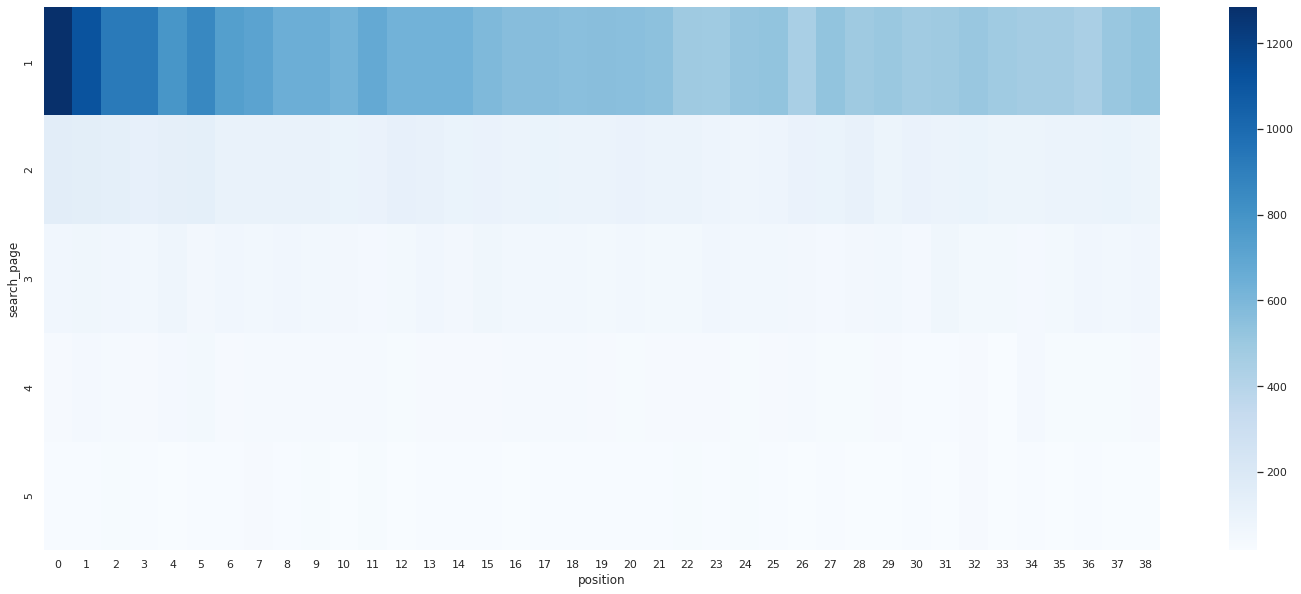

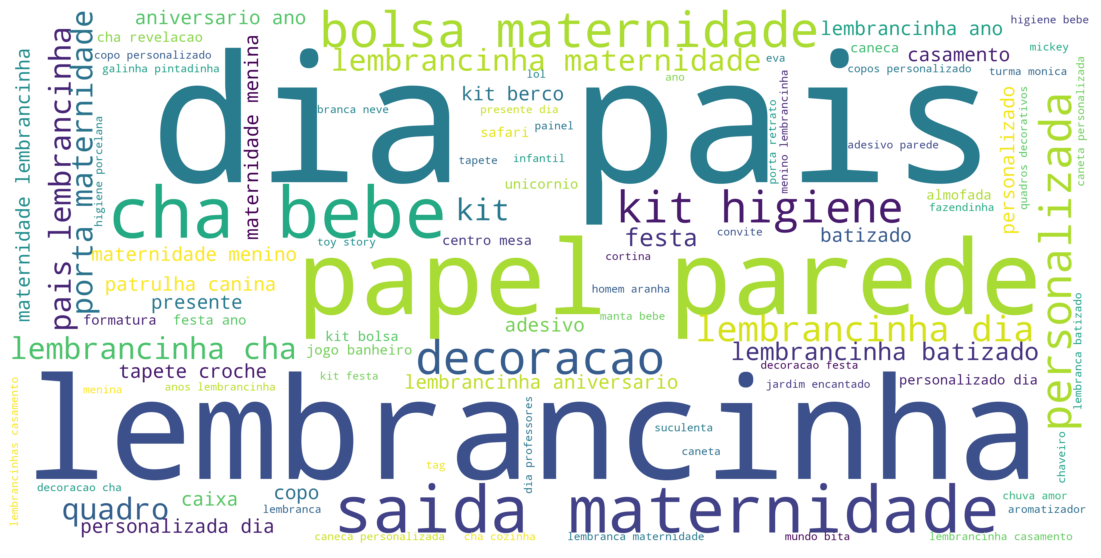

In [5]:
def format_search_space(base_frame: pd.DataFrame) -> pd.DataFrame:
    MAX_SEARCH_PAGE = max(5, base_frame['search_page'].max())
    MAX_POSITION = max(38, base_frame['position'].max())

    search_space_frame = pd.DataFrame(itertools.product(range(1, MAX_SEARCH_PAGE + 1),
                                                        range(0, MAX_POSITION + 1)),
                                      columns=['search_page', 'position'])

    agg_frame = (base_frame
                 [['search_page', 'position']]
                 .assign(registros=1)
                 .groupby(['search_page', 'position'])
                 .sum()
                 .reset_index()
                )

    agg_frame = (pd
                 .merge(search_space_frame, agg_frame, how='left', on=['search_page', 'position'])
                 .fillna(0)
                 .pivot(index='search_page', columns='position', values='registros')
                 )

    return agg_frame


def plot_query_heatmap(base_frame: pd.DataFrame, display_values=False) -> None: 

    ax = sns.heatmap(base_frame,
                     cmap="Blues",
                     annot=display_values
                    )
    plt.show()
    

partial_clean_text_fn = partial(clean_text,
                                unify_html_tags=False,
                                unify_urls=False,
                                trim_repeating_spaces=True,
                                unify_hashtags=False,
                                unify_mentions=False,
                                unify_numbers=False,
                                trim_repeating_letters=True,
                                lower_case=True,
                                remove_stopwords=True
                               )


display(HTML('<h3>Número de Interações por Página e Posição</h3>'))
plot_query_heatmap(format_search_space(frame))
display(HTML('<h4>Palavras das Buscas</h4>'))
plot_word_cloud(frame['query'].apply(partial_clean_text_fn).tolist())

Como resumo geral das buscas, é possível notar que das 5 páginas de resultado a primeira é a que possui maior número de interações. Nela, ocorreram cerca de 1200 interações com o primeiro produto dos resultados e há uma tendência de redução das interações conforme o item se posiciona mais ao fim da página.

Pela nuvem de palavras é possível notar a grande ocorrência de datas comemorativas (e.g., "dias dos pais" ), momentos comemorativos (e.g., 'chá de bebê', 'batizado' e 'formatura'), além de expressões gerais associadas a categorias de produtos (e.g., 'lembrancinha' e 'decobração'). A indicação de frequência de expressões gerais pode levar à percepção de que os dados se referem a um periodo mais específico do ano. Ainda assim, é possível notar a presença de expressões de busca que indicam mais foco, como 'tapete crocê', 'caneca personalizada', 'centro mesa' e 'kit higiene'. É de se esperar que expressões mais especializadas sejam pulverizadas e, assim, tenham menor frequência no texto, reduzindo seu destaque.

Para ajudar a ter uma noção do comportamento das pessoas que fazem busca, faz-se a divisão das buscas em 5 perfis, de acordo com a quantidade de produtos com interação.

Categorias: Decoração, Lembrancinhas


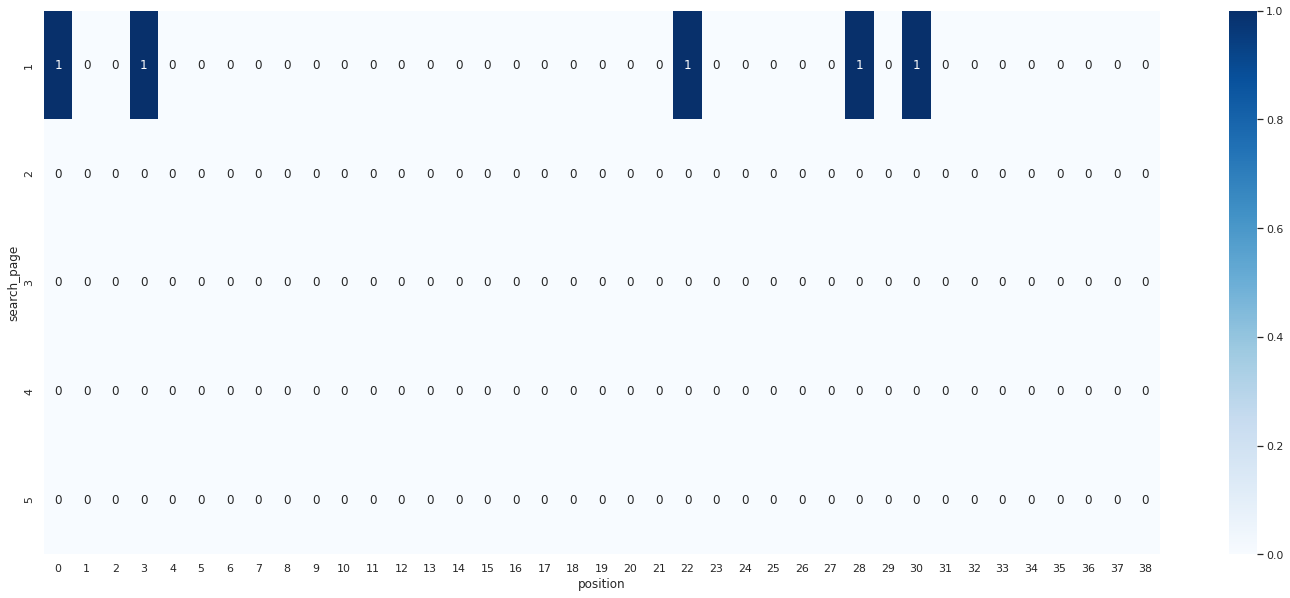

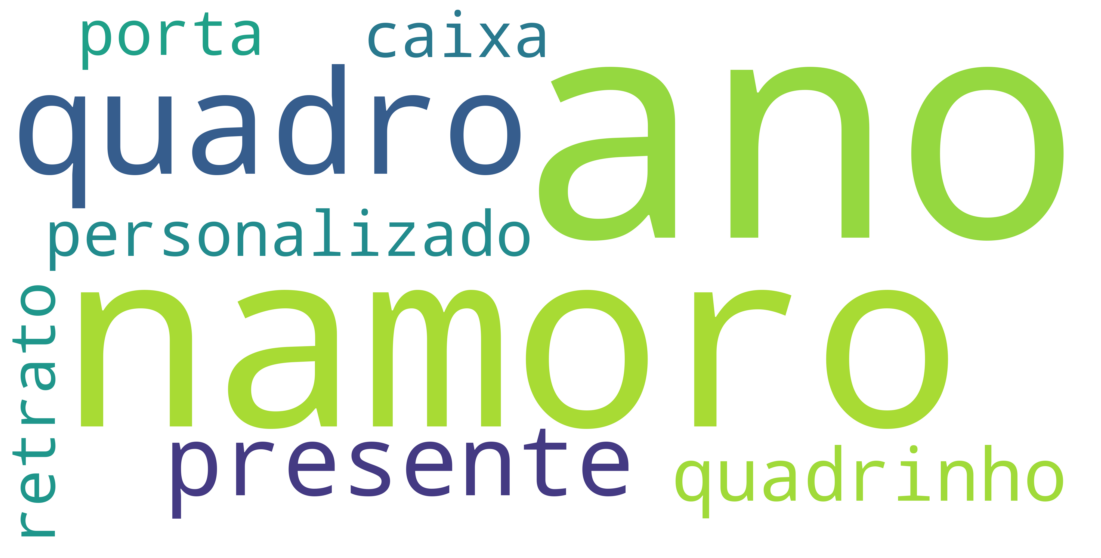

Categorias: Bebê, Decoração


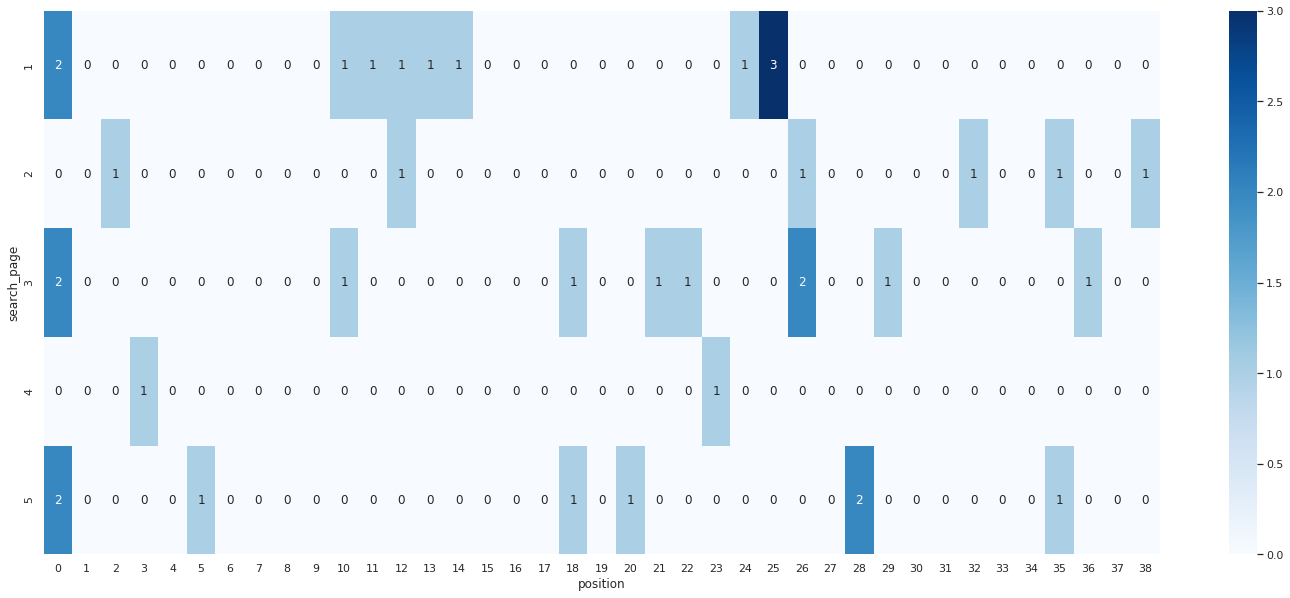

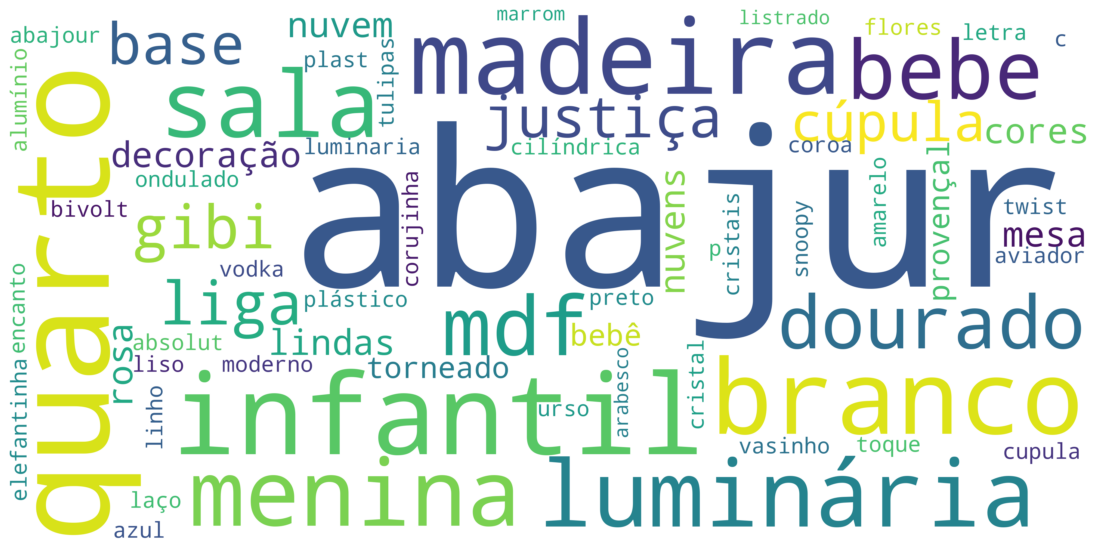

Categorias: Bebê, Lembrancinhas


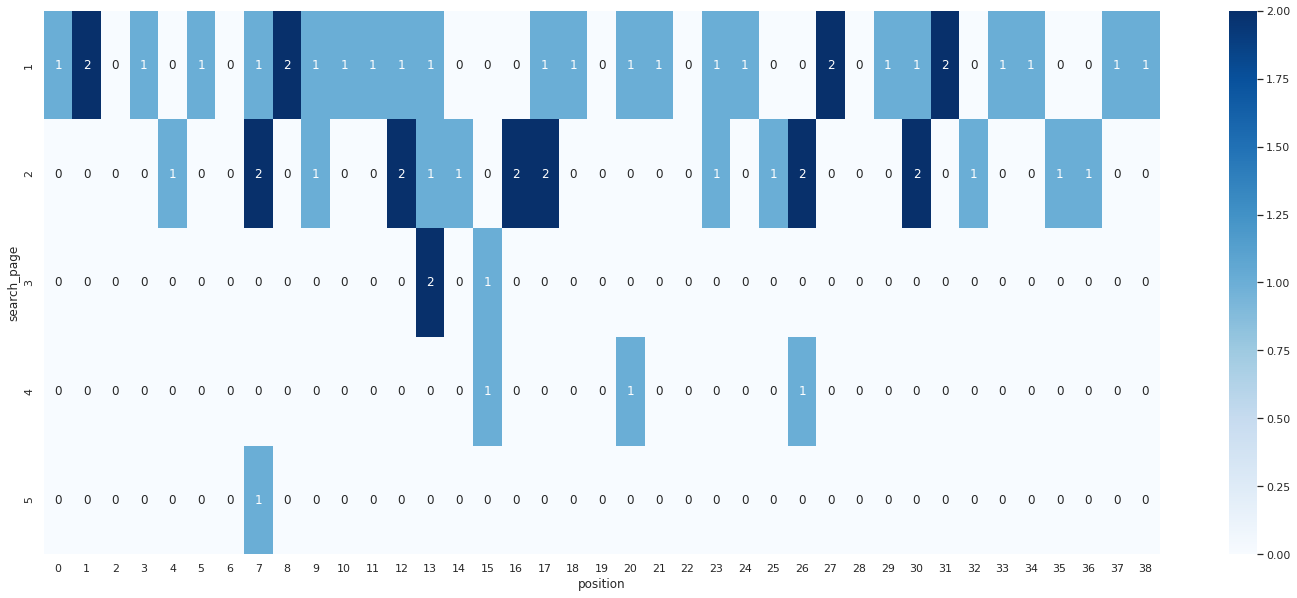

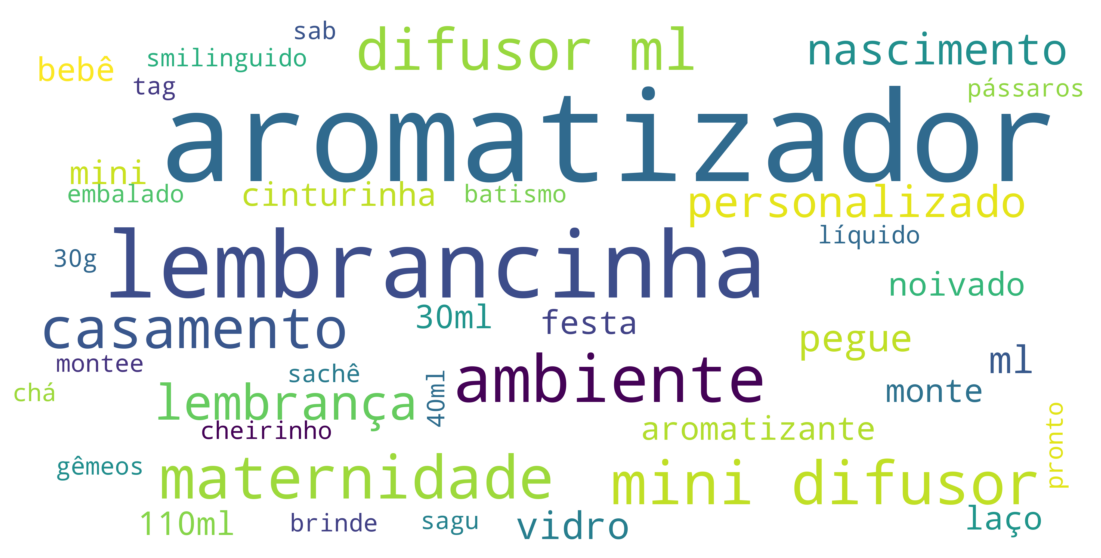

Categorias: Bebê


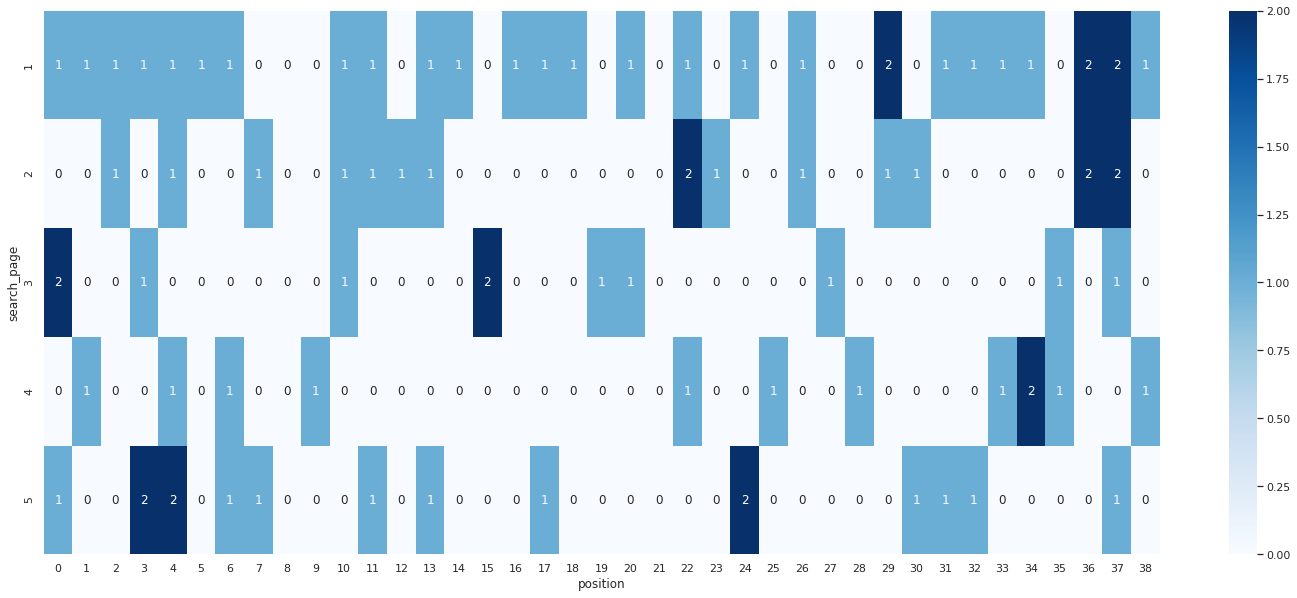

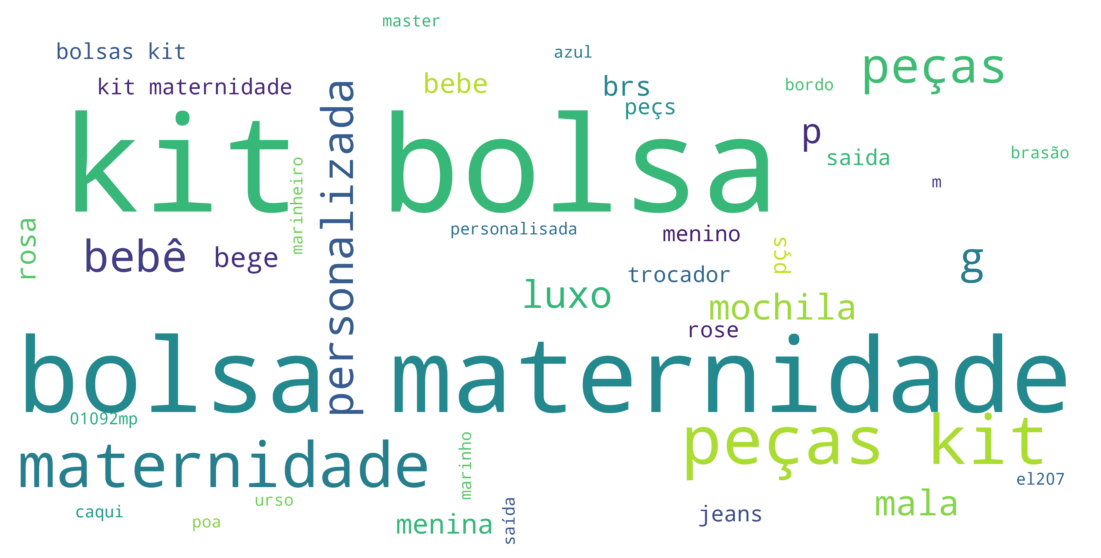

Categorias: Bebê, Decoração, Lembrancinhas, Papel e Cia


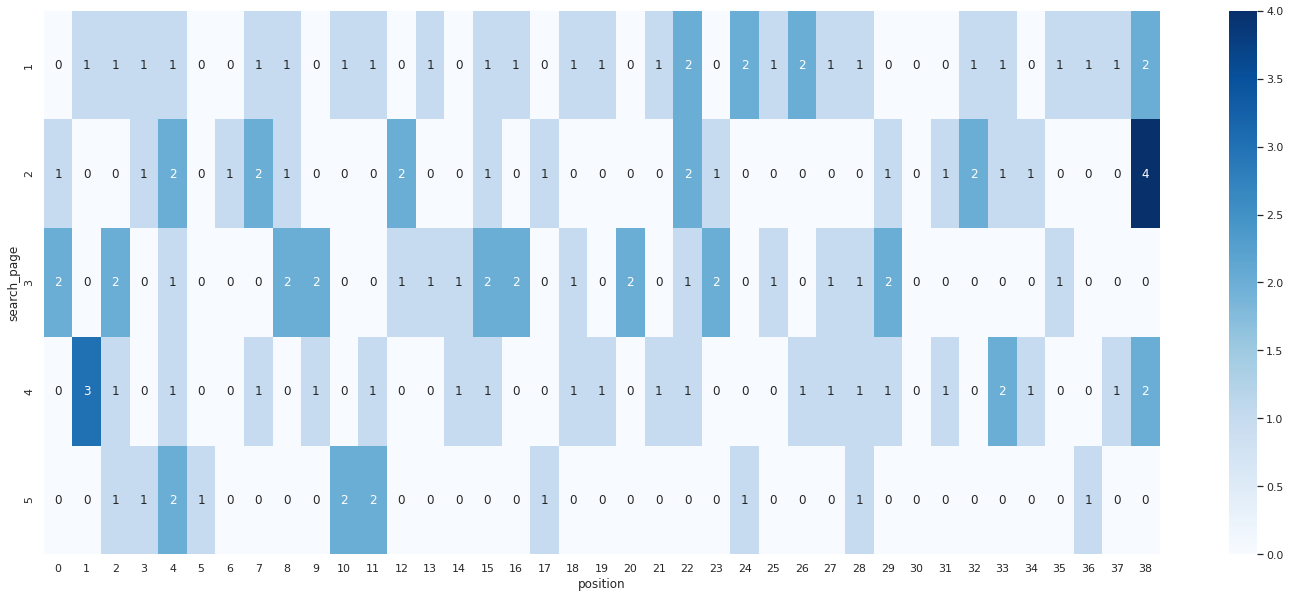

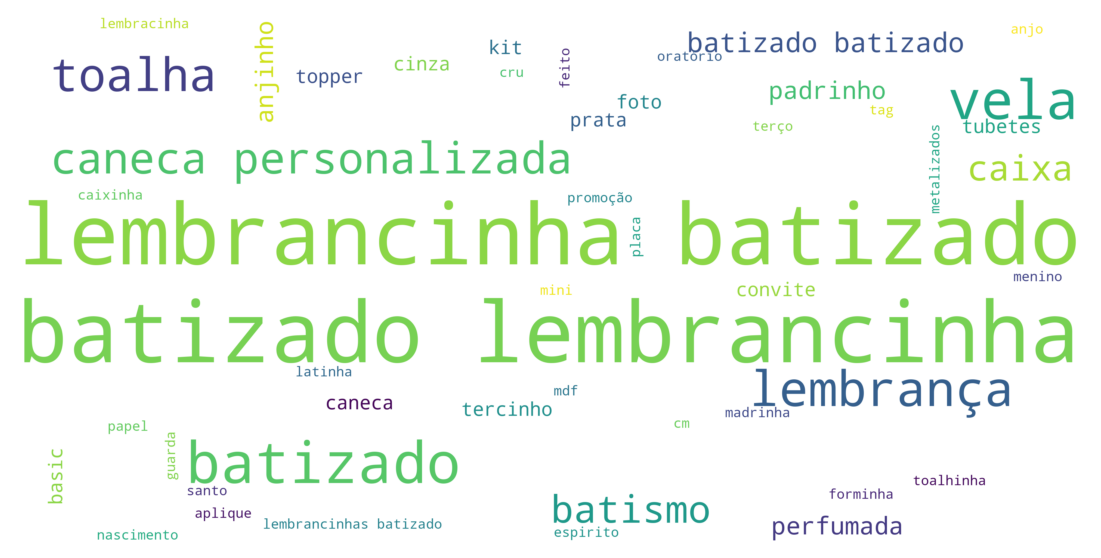

In [6]:
# Divide os registros em 5 grupos, de acordo com o número de interações por busca 
# e separa um elemento de cada grupo para exibição
representation_queries_frame = (frame
 [['query']]
 .assign(registros=1)
 .groupby('query')
 .sum()
 .reset_index()
 .assign(group=lambda f: pd.cut(f['registros'], bins=5, include_lowest=True))
 .drop_duplicates('group')
 .sort_values(by='registros') 
)

display(HTML('<h3>Interações e Resultados por Busca</h3>'))
for _, query in representation_queries_frame[['query']].itertuples():
    slice_frame = frame.loc[lambda f: f['query'] == query]
    display(HTML(f'<h4>Busca: <strong>{query}</strong> [{len(slice_frame)} interações]</h4>'))
    print(f'Categorias: {", ".join(sorted(slice_frame["category"].unique().tolist()))}')
    plot_query_heatmap(format_search_space(slice_frame), display_values=True)
    display(HTML('<h4>Palavras dos Títulos dos Produtos</h4>'))
    plot_word_cloud(slice_frame['title'].apply(partial_clean_text_fn).tolist())
    display(HTML('<br />'))
del slice_frame

Pelos resultados dos 5 perfis, é interessante notar como uma busca com poucos resultados com interações ('1 ano de namoro': 5) pode ter duas categorias de produtos, enquanto uma com muitas interações (' kit bolsa maternidade' - 85), tem apenas uma categoria de produto. Isso pode ser entendido como um indício de que é possível identificar buscas focadas com grande número de produtos explorados, mas com um tipo de produto bem definido.

## Análise de *Embeddings*

Como o intuito é entender como buscas e produtos se relacionam entre ou em relação a seus pares, utiliza-se, novamente, a representação do conteúdo como *embeddings*. Com isso, tem-se a inclusão de alguns relacionamentos semânticos entre as palvras.

In [7]:
embeddings_frame = pd.concat([frame, compute_embeddings_frame(frame, ['query', 'title'])], axis=1)

Para permitir a visualização da relação entre os elementos em um plano, utiliza-se o UMAP para fazer a redução de dimensionalidade para 2 dimensões. O t-SNE foi substituído pelo [UMAP](https://umap-learn.readthedocs.io/en/latest/) pelo entendimento que se tem de que o segundo tende a preservar melhor as estruturas globais dos elementos e, assim, oferecer uma visualização mais consistente com relação à distância entre os elementos.

In [8]:
umap_reducer = umap.UMAP(n_neighbors=200, metric='cosine')

for column in ['query', 'title']:
    X = np.stack(embeddings_frame[f'{column}_embedding'].to_numpy(), axis=0)
    embeddings_frame[[f'{column}_embedding_reduced_x', f'{column}_embedding_reduced_y']] = umap_reducer.fit_transform(X)

del X

A seguir, explora-se o comportamento de buscas e produtos com relação às categorias. Enquanto é possível notar uma aproximação de produtos com a mesma categoria, é difícil notar algum padrão no comportamento das buscas com relação às categorias.

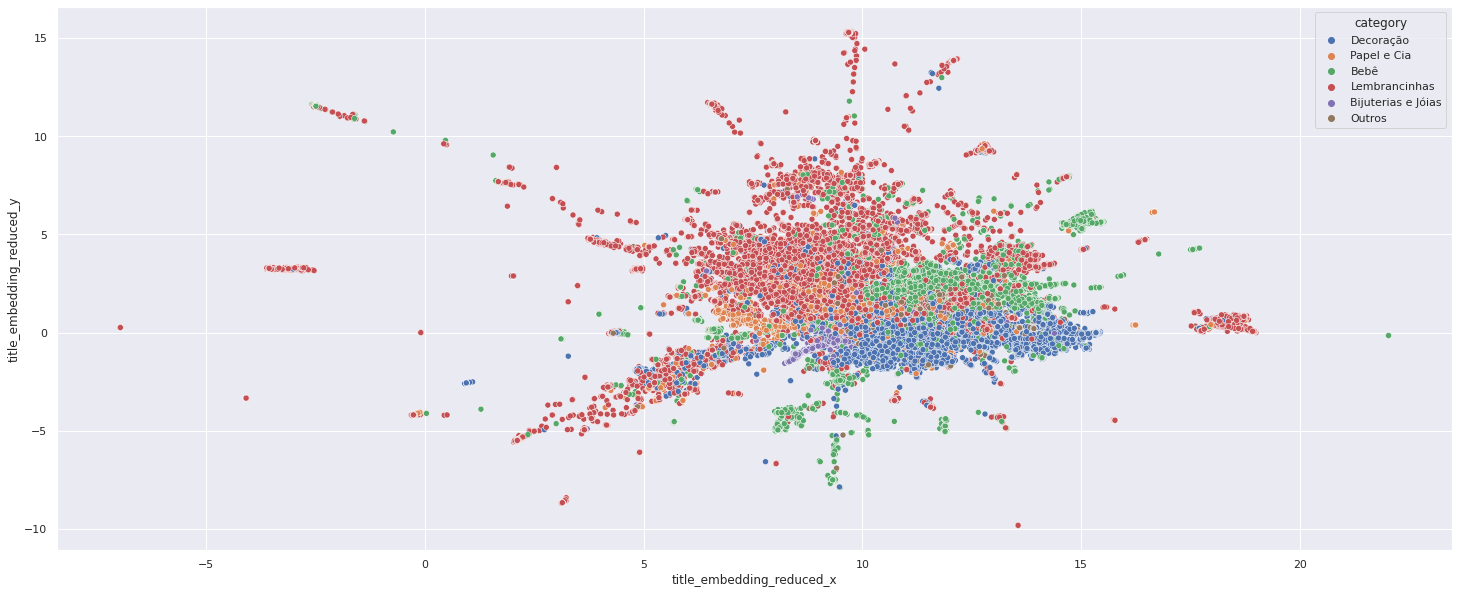

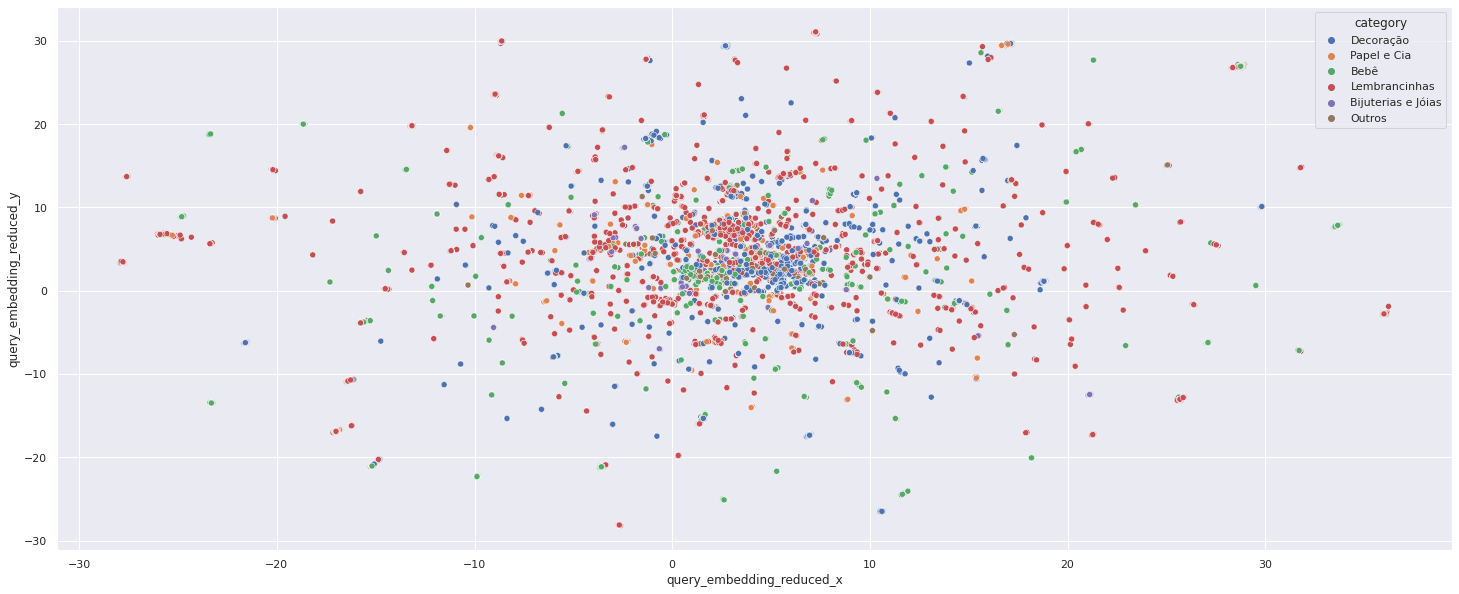

In [9]:
def plot_query_embeddings(base_frame: pd.DataFrame,
                          x_column: str,
                          y_column: str,
                          title: str = None,
                          hue: str = None) -> None:
    if title:
        formatted_column = ' '.join([item.capitalize() for item in title.split('_')])
        display(HTML(f'<h3>{formatted_column}</h3>'))

    g = sns.scatterplot(x=x_column, y=y_column, data=base_frame, hue=hue)
    g.xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.show()

# Extrai a lista de colunas com embeddings criados
embeddings_columns = set([column.split('_embedding_reduced')[0]
                          for column in embeddings_frame.columns 
                          if 'embedding_reduced' in column])

# Ordena colunas extraídas por tamanho, para manter ordem de atômico para composto
embeddings_columns = sorted(embeddings_columns, key=lambda ec: len(ec))

for column in embeddings_columns:
    plot_query_embeddings(embeddings_frame,
                          f'{column}_embedding_reduced_x',
                          f'{column}_embedding_reduced_y',
                          column,
                          'category'
                            )

## Entropia

Considerando o propósito de identificar a intenção da busca entre quem está com **foco** ou quer **explorar**, supõe-se que a primeira intenção deve apresentar menor heterogeneidade com relação aos itens com os quais se interage do que a segunda intenção. Para conseguir medir a heterogeneidade, tem-se tem como proposta o uso da entropia das categorias dos elementos interagidos para cada busca. 

In [10]:
def compute_entropy(labels, base=None):
    """ Source: https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python """

    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.

    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

Para determinar a heterogeneidade da composição dos elementos de interesse em uma busca, é preciso que exista ao menos 2 elementos. Além disso, como não se sabe se uma busca levou a pessoa a comprar ou não um produto, e nem se a pessoa fez uma nova busca, não é possível saber se a existência de um único elemento da busca é consequência do cumprimento do objetivo, desistência ou alteração da busca. Assim, para considerar as buscas como qualificadas para análise determinou-se a necessidade de ao menos 2 elementos com interações.

In [11]:
qualified_queries = set(frame
                        [['query']]
                        .assign(registros=1)
                        .groupby('query')
                        .sum()
                        .reset_index()
                        .query('registros >= 2')
                        ['query']
                        .unique()
                        .tolist()
                       )

embeddings_entropy_frame = (embeddings_frame
                            .loc[lambda f: f['query'].isin(qualified_queries)]
                            [['query', 'query_embedding', 'query_embedding_reduced_x', 'query_embedding_reduced_y']]
                            .drop_duplicates('query')
                           )

entropies = []
for query in embeddings_entropy_frame['query'].unique().tolist():
    entropies.append(compute_entropy(embeddings_frame
                                     .loc[lambda f: f['query'] == query]
                                     .category
                                     .to_numpy())
                    )

embeddings_entropy_frame['entropy'] = entropies

Ao observar o comportamento da busca com relação ao valor de entropia de seus elementos com interação, não é possívle observar uma separação clara. Elementos homogêneos com relação à categoria (entropia 0) estão dispersos no espaço assim como os que têm alguma heterogeneidade.

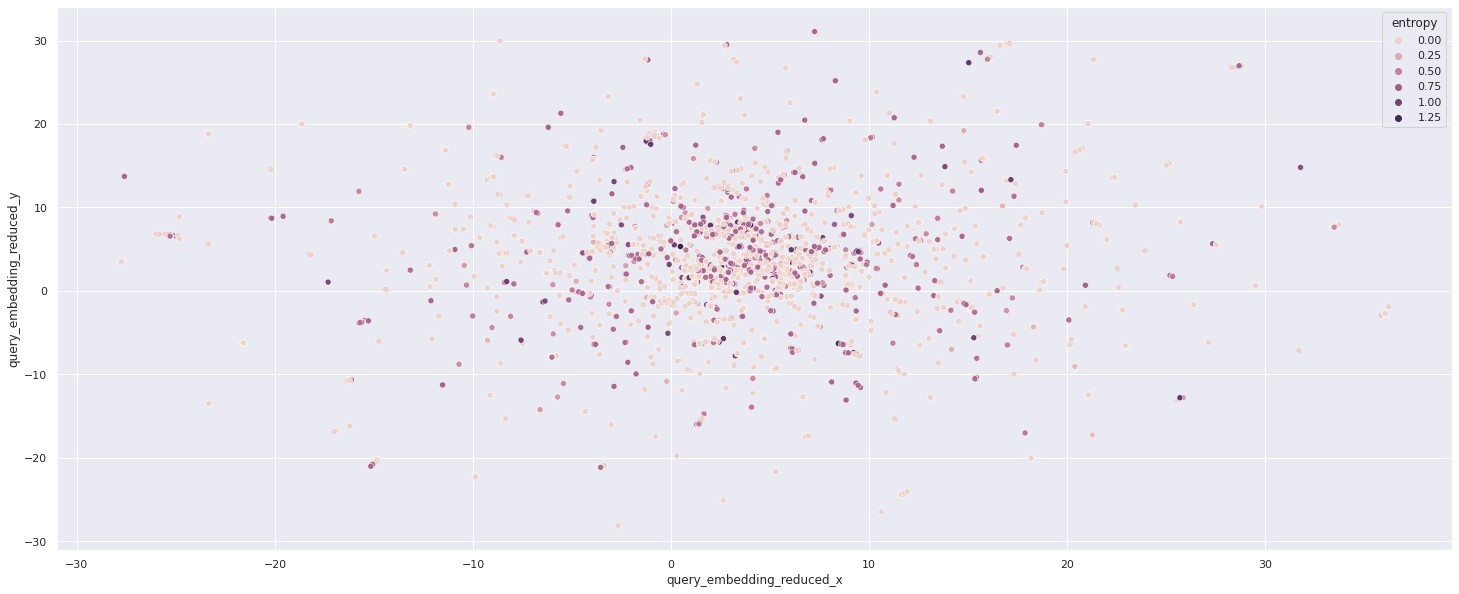

In [12]:
plot_query_embeddings(embeddings_entropy_frame,
                      f'query_embedding_reduced_x',
                      f'query_embedding_reduced_y',
                      'query',
                      'entropy'
                     )

Para tentar identificar algum padrão, os elementos são divididos em grupos de 2 a 5 níveis de entropia.

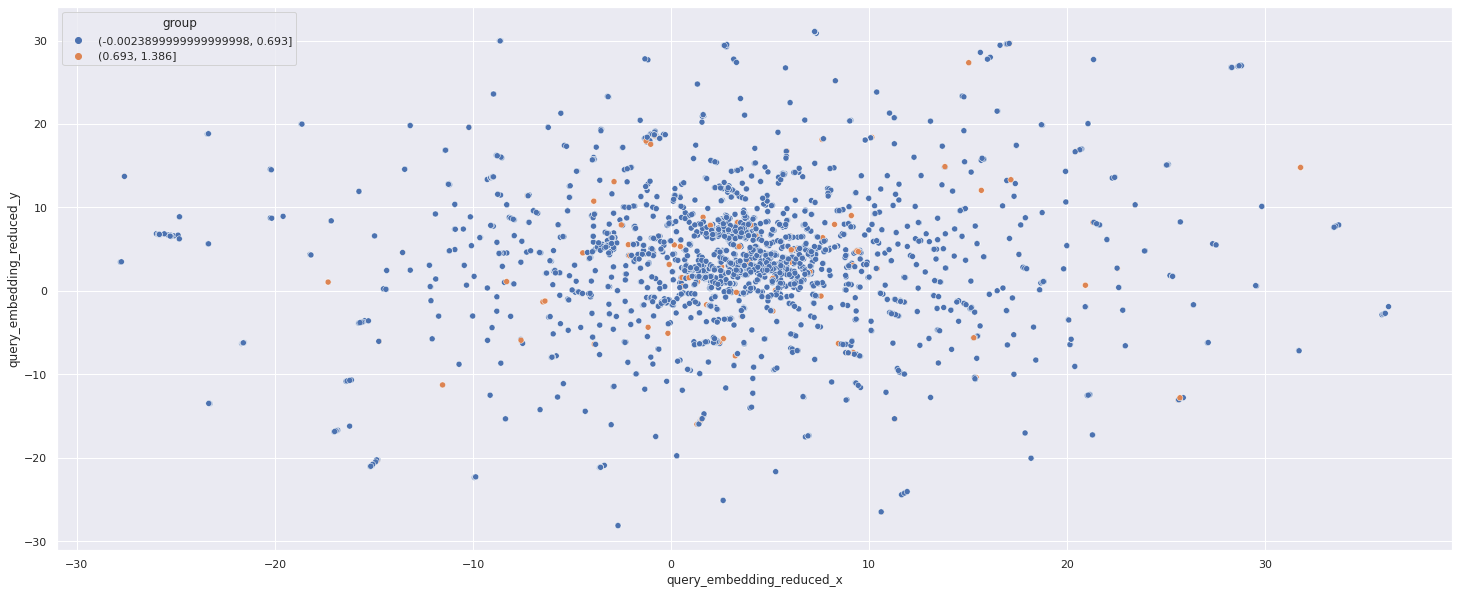

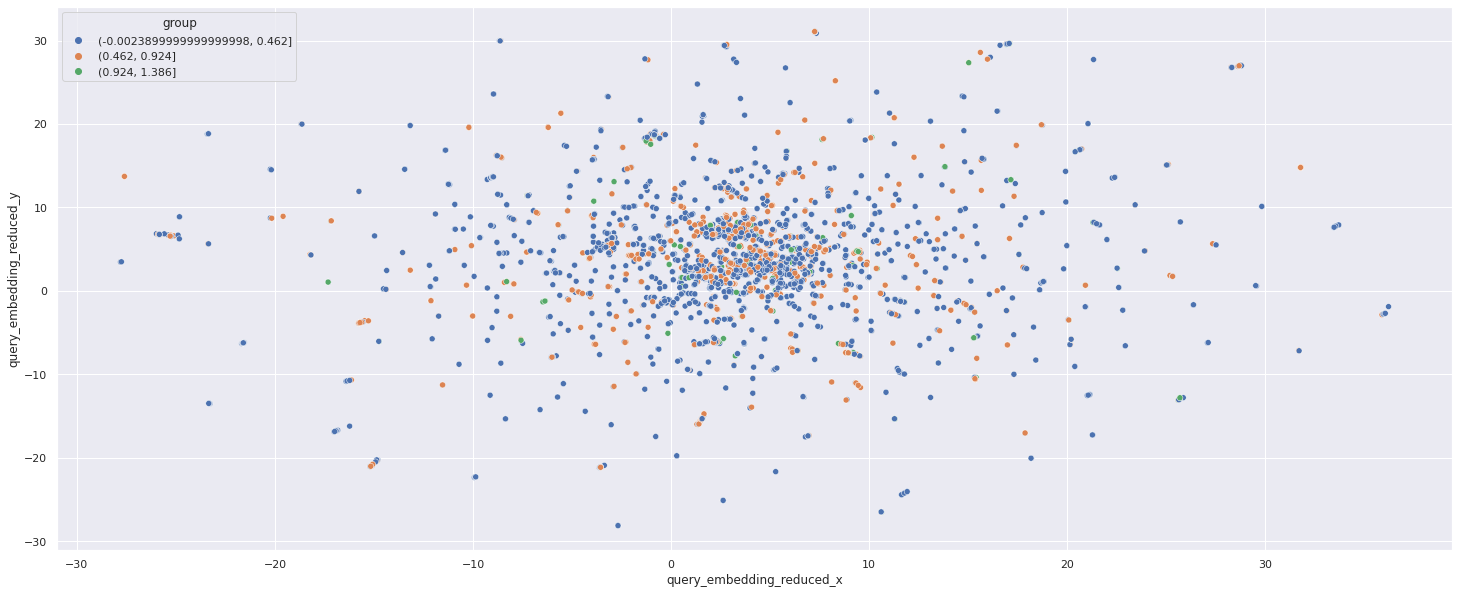

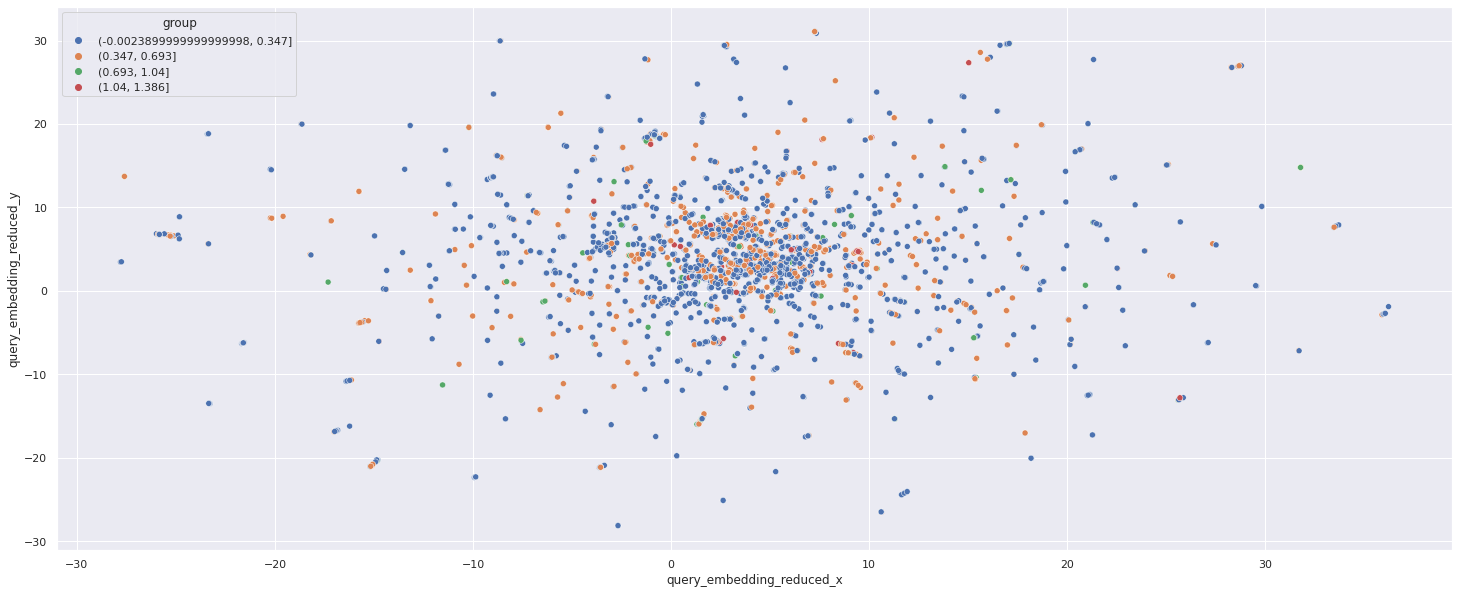

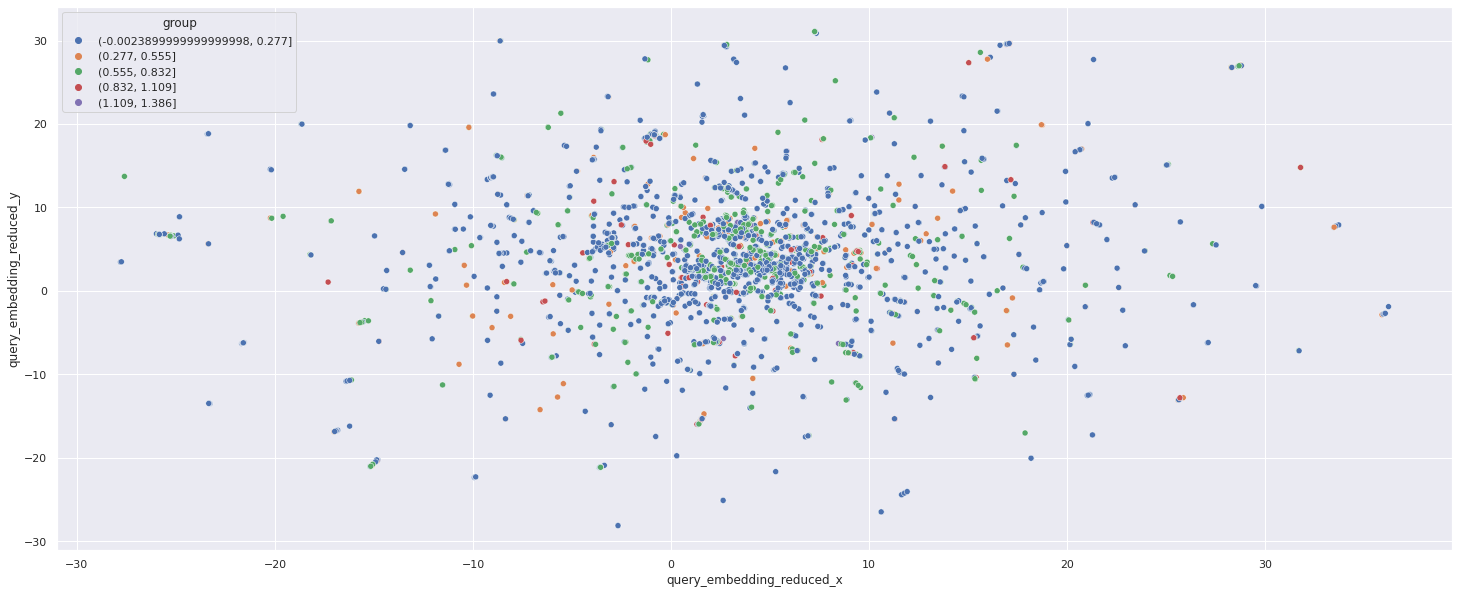

In [13]:
for bin_size in range(2, 6):
    plot_query_embeddings(embeddings_entropy_frame.assign(group=lambda f: pd.cut(f['entropy'], bins=bin_size, include_lowest=True)),
                          f'query_embedding_reduced_x',
                          f'query_embedding_reduced_y',
                          f'{bin_size} Groups',
                          'group'
                         )

Como se pode observar, mesmo com as diferentes divisões de grupos de homogeneidade não é possível notar um padrão claro de separação com relação às buscas. Uma hipótese para isso é o número baixo de categorias disponíveis e a ambiguidade existente entre algumas das categorias, como se pôde observar na tarefa de classificação.


Uma forma de contornar o problema é tentar determinar um número maior de categorias entre os produtos. Para isso, será feito um agrupamento dos produtos utilizando o [Gaussian Mixture](https://scikit-learn.org/stable/modules/mixture.html#gmm). Para ter noção da quantidade de grupos (no modelo, tratado como componentes) a ser utilizado, vários modelos são criados e avaliados com relação ao BIC e AIC, que devem ser minimizados.

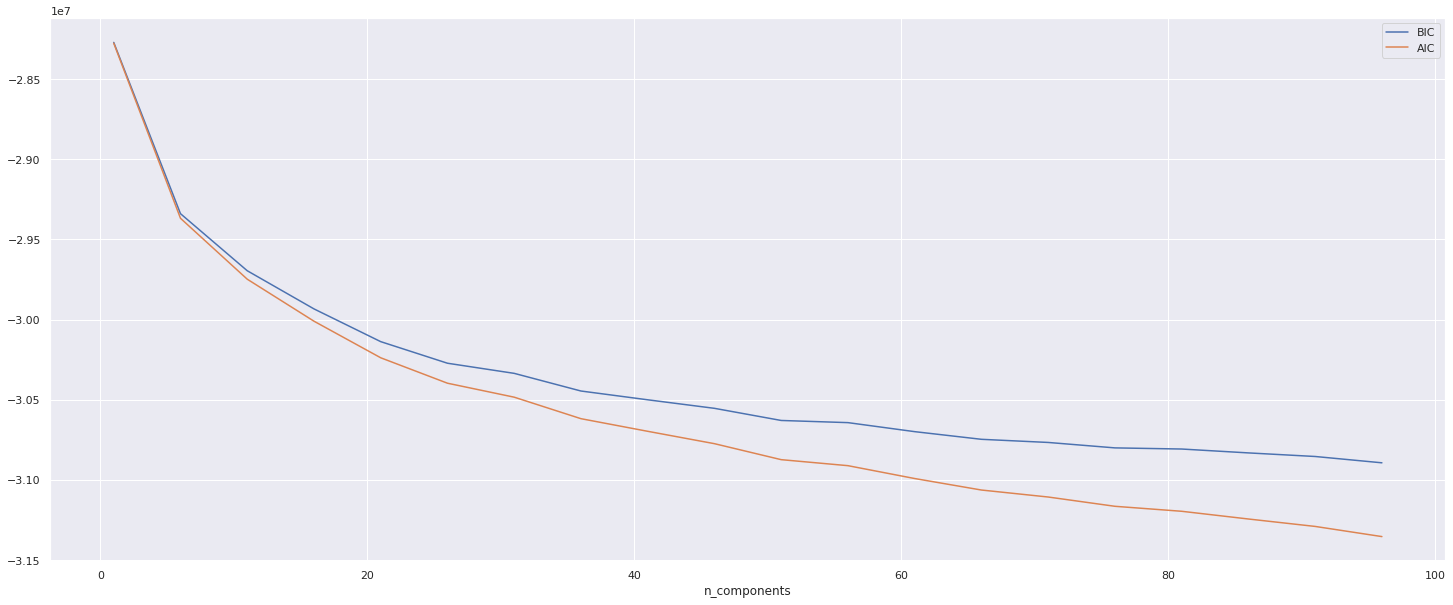

In [14]:
embedding_columns = 'title_embedding'

products_embeddings_frame = (embeddings_frame
                             .drop_duplicates('title')
                             [['title', 'title_embedding', 'title_embedding_reduced_x', 'title_embedding_reduced_y']]
                            )

X = np.stack(products_embeddings_frame[embedding_columns].to_numpy(), axis=0)

n_components = np.arange(1, 100, 5)
models = [GaussianMixture(n, covariance_type='diag', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

Ainda que se possa continuar explorando o aumento do número de componentes para minimizar o valor das métricas, assume-se que um valor de 50 componentes já contribuiria para uma melhor distinção entre as características dos produtos e não se distancia tanto de um número maior de componentes que, pelo gráfico, parece se aproximar de uma convergência. Considerando o total de 21509 produtos únicos nos dados, tem-se em média 430 produtos por componente.

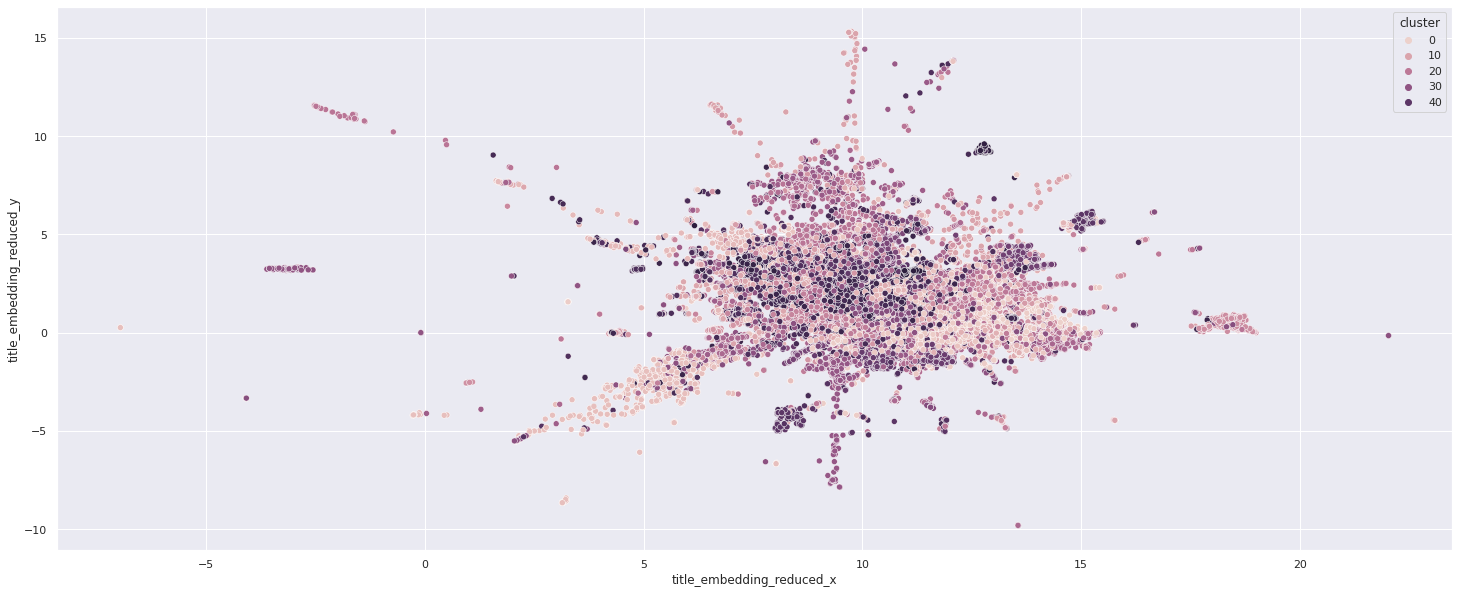

In [15]:
products_embeddings_frame = (embeddings_frame
                             .drop_duplicates('title')
                             [['title', 'title_embedding', 
                               'title_embedding_reduced_x', 'title_embedding_reduced_y']]
                            )

X = np.stack(products_embeddings_frame[f'title_embedding'].to_numpy(), axis=0)

gmm = GaussianMixture(n_components=50, covariance_type="diag").fit(X)
products_embeddings_frame['cluster'] = gmm.predict(X)


plot_query_embeddings(products_embeddings_frame,
                      f'title_embedding_reduced_x',
                      f'title_embedding_reduced_y',
                      'title',
                      'cluster'
                     )

del X

Como o gráfico indica, não é possível determinar claramente uma separação entre os grupos e os produtos, ainda que existam grupos ocasionais perceptíveis. Para poder analisar melhor a separação, alguns casos serão analisados. Para isso, primeiro faz-se a associação dos grupos com os dados de *embeddings* das buscas e seus resultados.

In [16]:
embeddings_frame = pd.merge(embeddings_frame, products_embeddings_frame[['title', 'cluster']], on='title', how='left')
embeddings_frame.head()

product_id                                query  search_page  position  \
0    11394449                       espirito santo            2         6   
1    15534262                     cartao de visita            2         0   
2    15877252  medidas lencol para berco americano            1         6   
3    15917108                 adesivo box banheiro            3        38   
4     4336889                         dia dos pais            1        37   

                              title  \
0            Mandala Espírito Santo   
1                  Cartão de Visita   
2    Jogo de Lençol Berço Estampado   
3           ADESIVO BOX DE BANHEIRO   
4  Álbum de figurinhas dia dos pais   

                                               concatenated_tags  \
0                                                    mandala mdf   
1  cartao visita panfletos tag adesivos copos long drink canecas   
2                              t jogo lencol menino lencol berco   
3                                           adesivo box banheiro   
4                        albuns figurinhas pai lucas album fotos   

         creation_date       category  \
0  2015-11-14 19:42:12      Decoração   
1  2018-04-04 20:55:07    Papel e Cia   
2  2017-02-27 13:26:03           Bebê   
3  2017-05-09 13:18:38      Decoração   
4  2018-07-11 10:41:33  Lembrancinhas   

                                                                                                                                         query_embedding  \
0  [0.004229284, -0.027336909, 0.030303514, 0.069929294, 0.020897388, -0.06250459, 0.050103087, -0.058517657, -0.08247556, -0.11175527, -0.06378104, ...   
1  [-0.026694268, -0.017967489, 0.033112615, 0.014724638, -0.05641233, -0.075842515, -0.024225041, -0.01875468, 0.020485003, -0.0123114195, 0.0144400...   
2  [-0.009937028, -0.03977453, -0.012446368, 0.017117713, -0.015563251, -0.03873233, -0.0033934943, -0.031354975, 0.031865496, -0.034994584, 0.022870...   
3  [-0.026621936, -0.073510095, 0.075533554, 0.07262413, 0.019082194, -0.06852277, -0.06993433, -0.0023695014, -0.004398109, -0.103189036, -0.0423375...   
4  [-0.055642586, -0.017499804, 0.032370105, -0.014251055, 0.019531108, 0.011841396, 0.04564786, -0.025915068, -0.00044952458, -0.09124371, -0.003560...   

                                                                                                                                         title_embedding  \
0  [-0.008050227, -0.008805177, 0.05007785, 0.052670166, -0.008375991, -0.08733791, 0.08137107, -0.047023904, -0.084045015, -0.114914, -0.015285425, ...   
1  [-0.045109227, -0.025397679, 0.03495742, 0.0006268186, -0.058263194, -0.07574056, -0.011842876, -0.024876617, 0.008490498, -0.011903388, 0.0148019...   
2  [-0.009625531, -0.0075558904, 0.04198961, -0.021121407, 0.009023795, -0.057901293, 0.0071319044, 0.0013754551, -0.006352756, -0.032950606, 0.01115...   
3  [-0.018868096, -0.06439885, 0.059289288, 0.054038137, -0.010600663, -0.051247593, -0.054422166, 0.0020310725, 0.00487231, -0.05863656, -0.02942790...   
4  [-0.027158957, -0.027052542, 0.01778969, -0.028899949, -0.017072415, -0.01605464, -0.0044643283, -0.0142439585, -0.011826115, -0.036974575, 0.0142...   

   query_embedding_reduced_x  query_embedding_reduced_y  \
0                  12.099756                   4.229313   
1                  -8.086547                   8.710782   
2                   6.444048                   0.193104   
3                  -6.614747                 -14.246532   
4                  17.086424                  29.641535   

   title_embedding_reduced_x  title_embedding_reduced_y  cluster  
0                   9.912788                   7.997636       27  
1                  12.075489                   4.463694       13  
2                  11.841559                   1.584314       20  
3                  11.173842                  -1.888777        7  
4                   5.266156                  -3.494932        4

Para analisar a composição dos grupos, obtém-se 5 elementos de grupos distintos.

Pelos exemplos, os grupos seriam:
 - **Grupo 4**: produtos personalizados, principalmente relacionados a sacolas, bolsas, mochilas e similares.
 - **Grupo 16**: lembrancinhas e presentes para aniversário.
 - **Grupo 20**: produtos temáticos envolvendo A Bela e a Fera, Turma da Mônica e outros.
 - **Grupo 23**: canecas, copos e similares personalizados.
 - **Grupo 48**: produtos personalizados para comemorar maternidade.

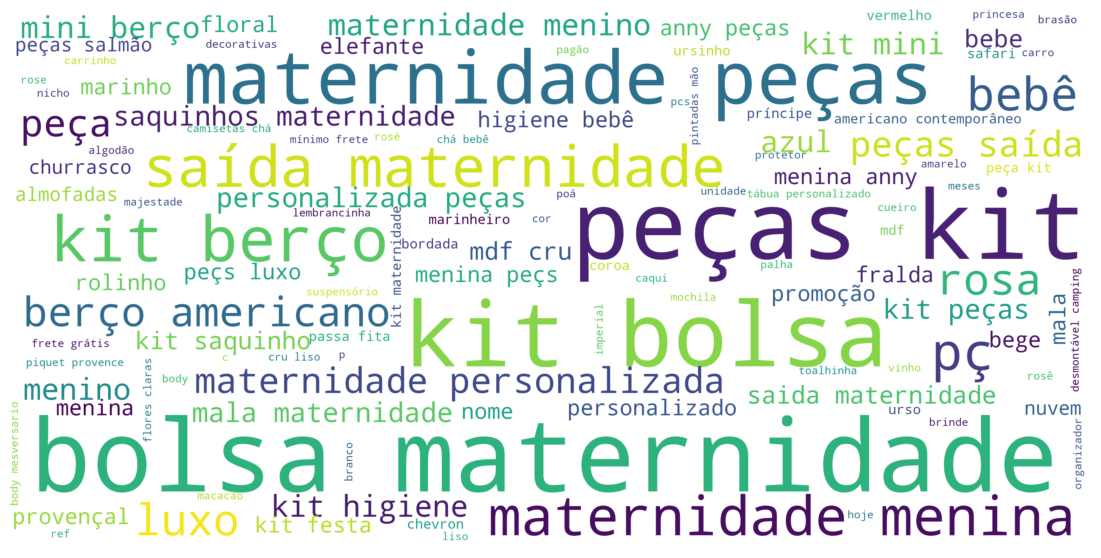

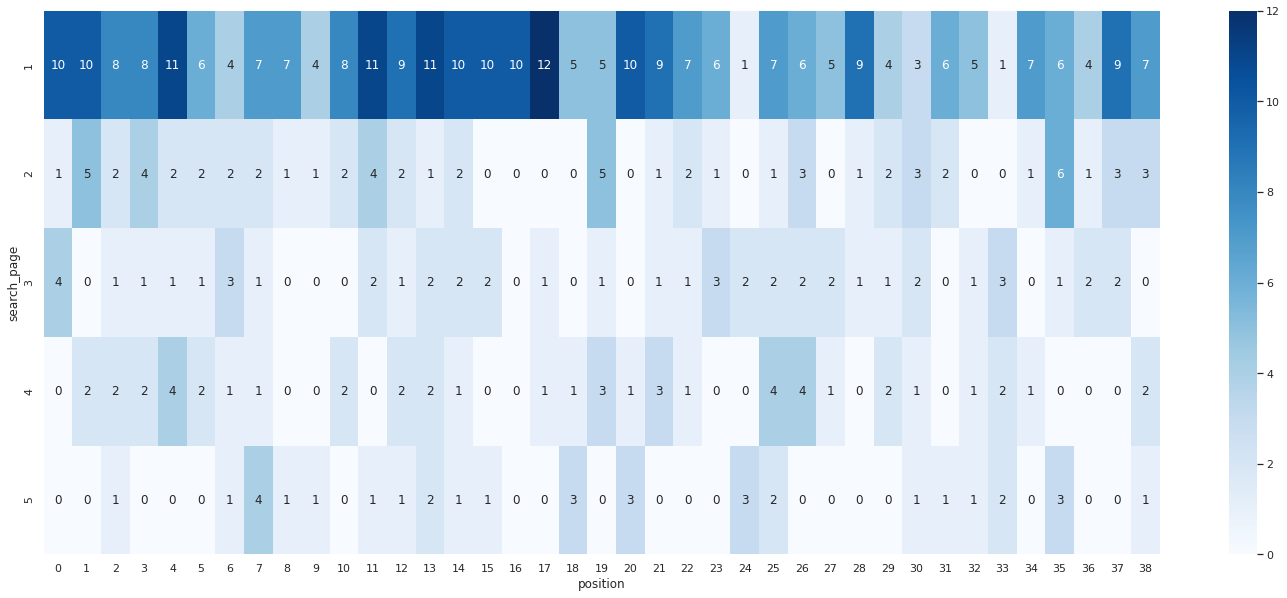

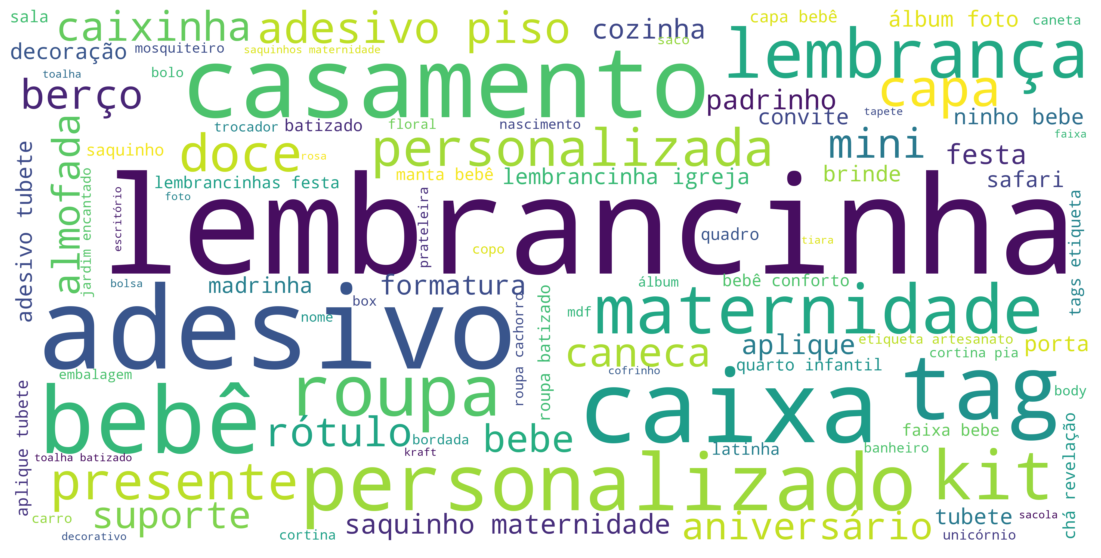

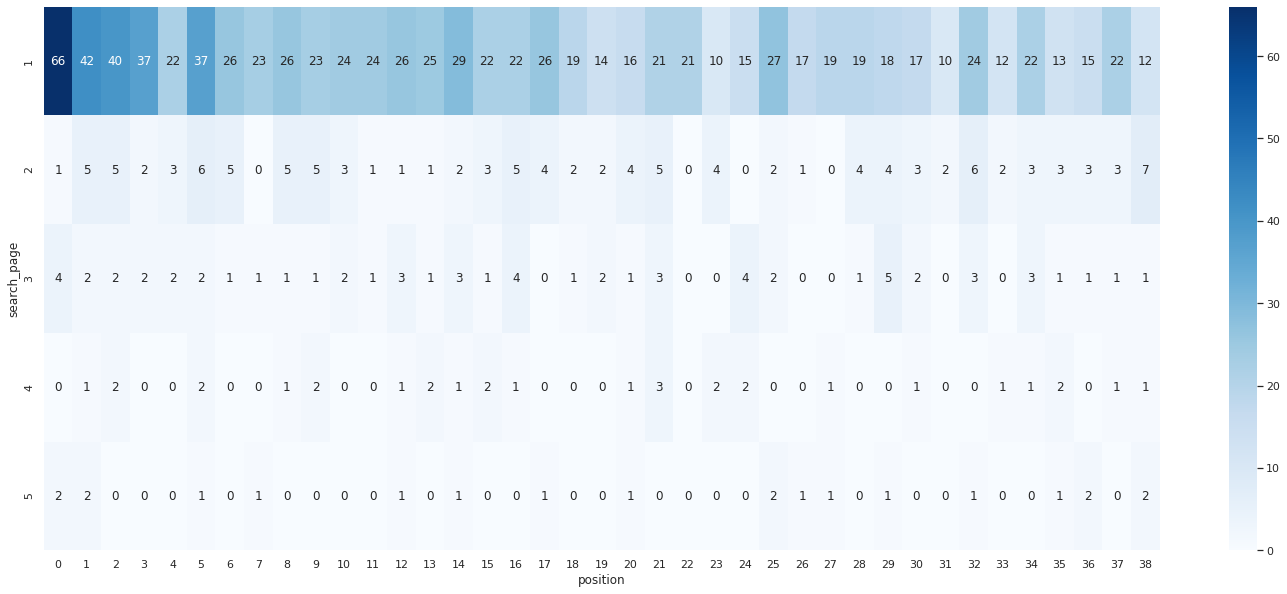

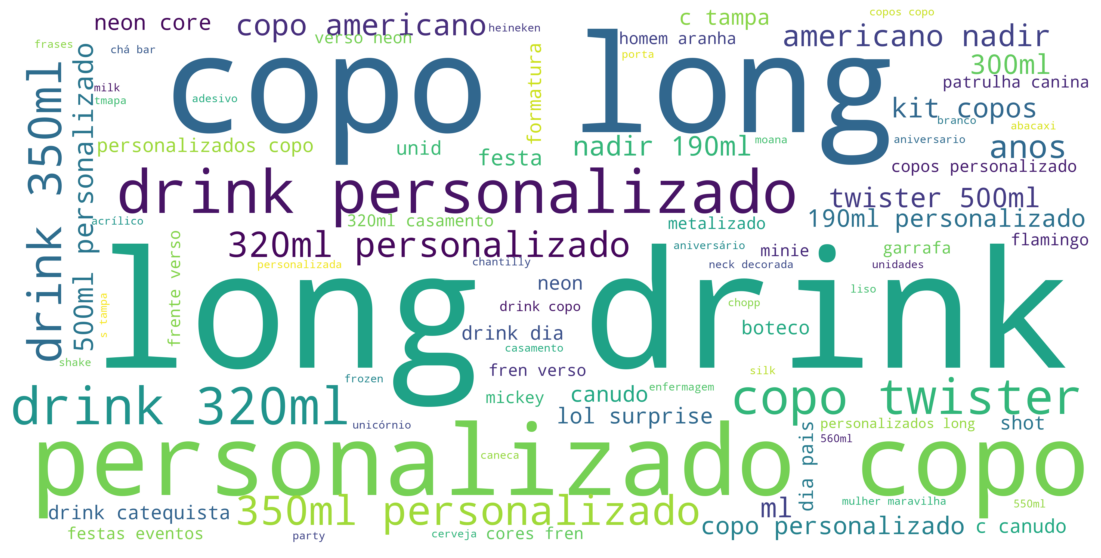

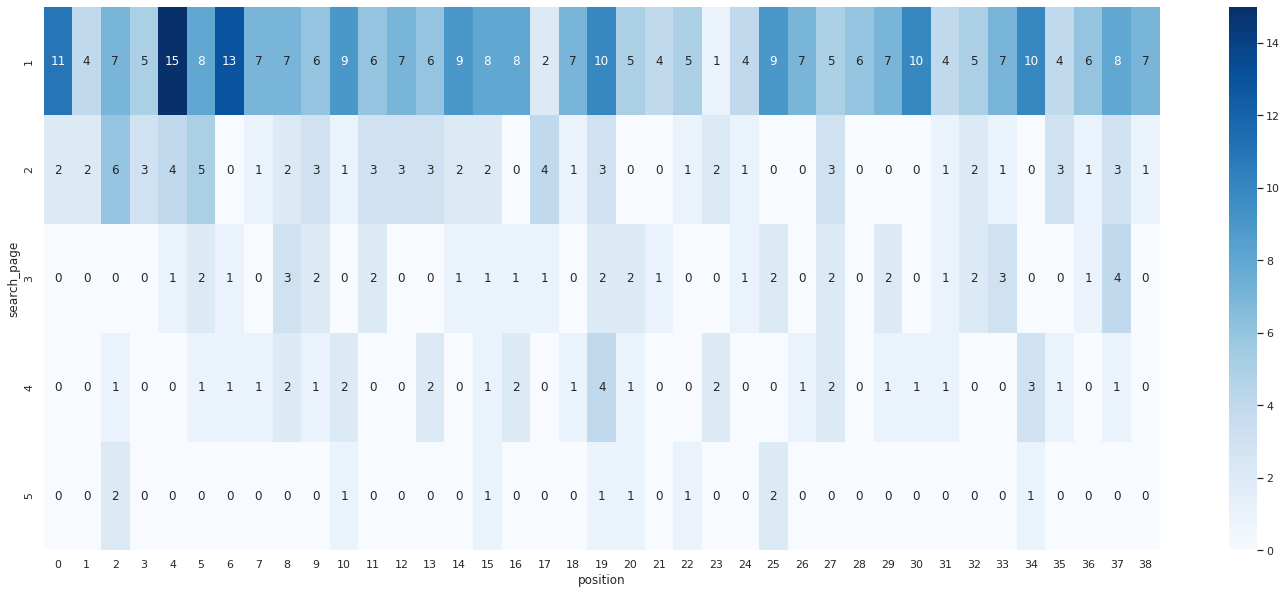

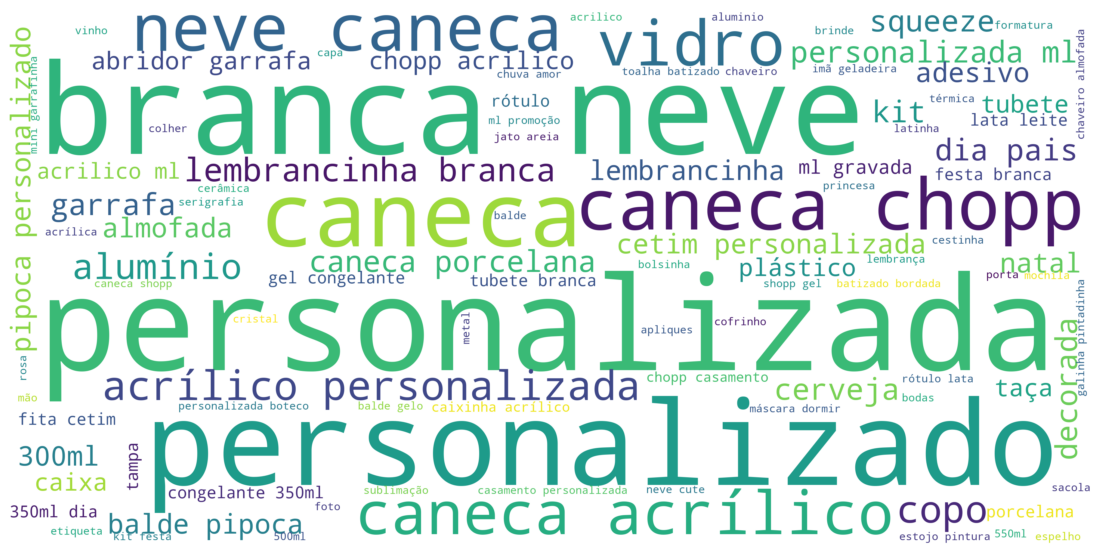

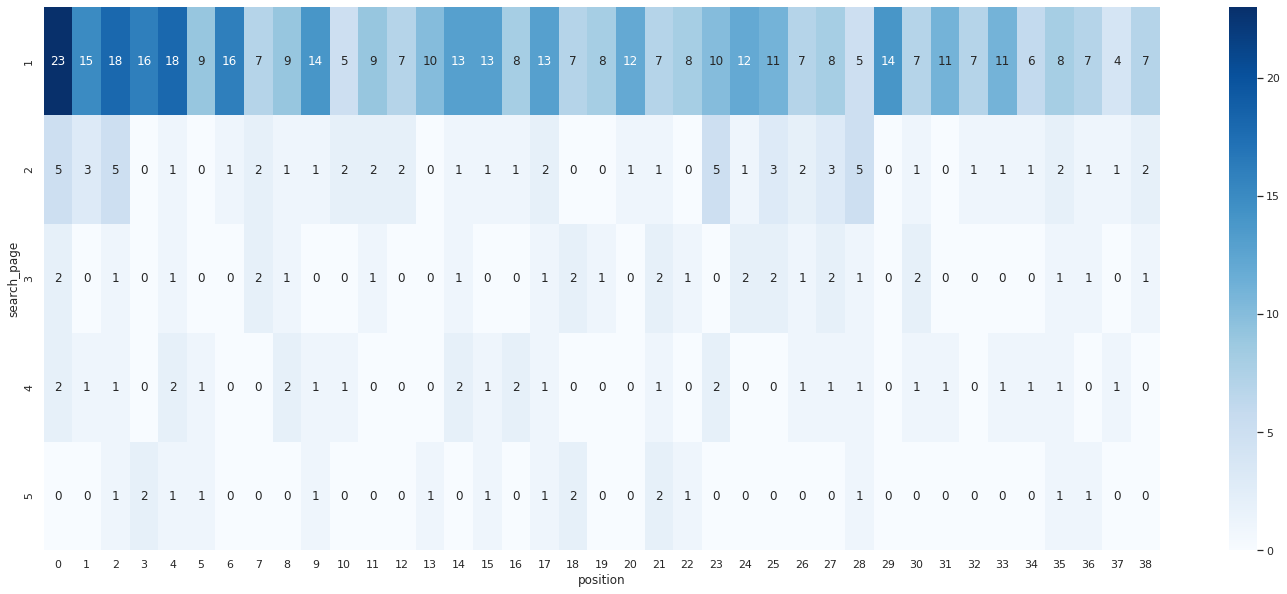

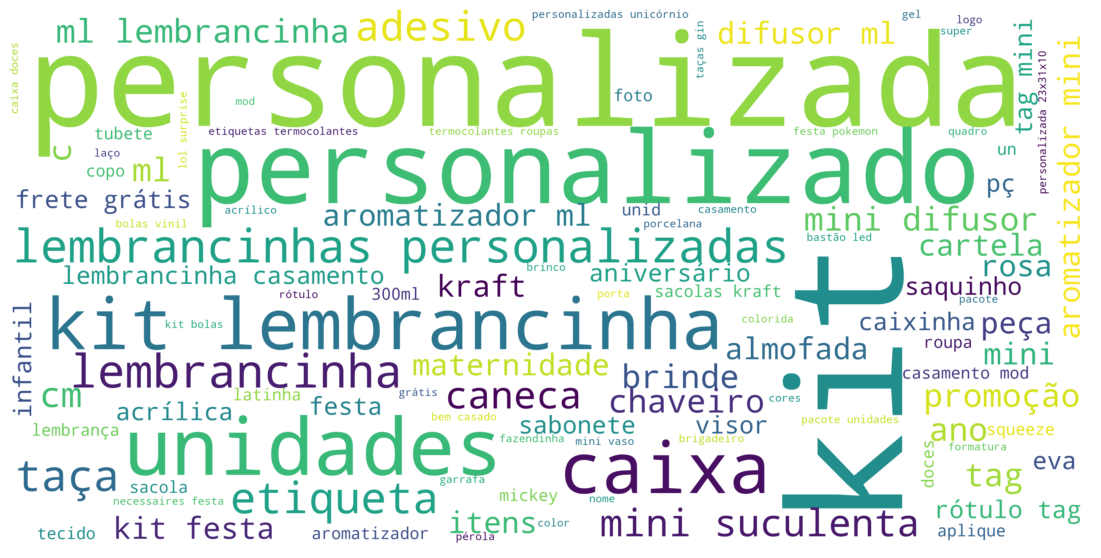

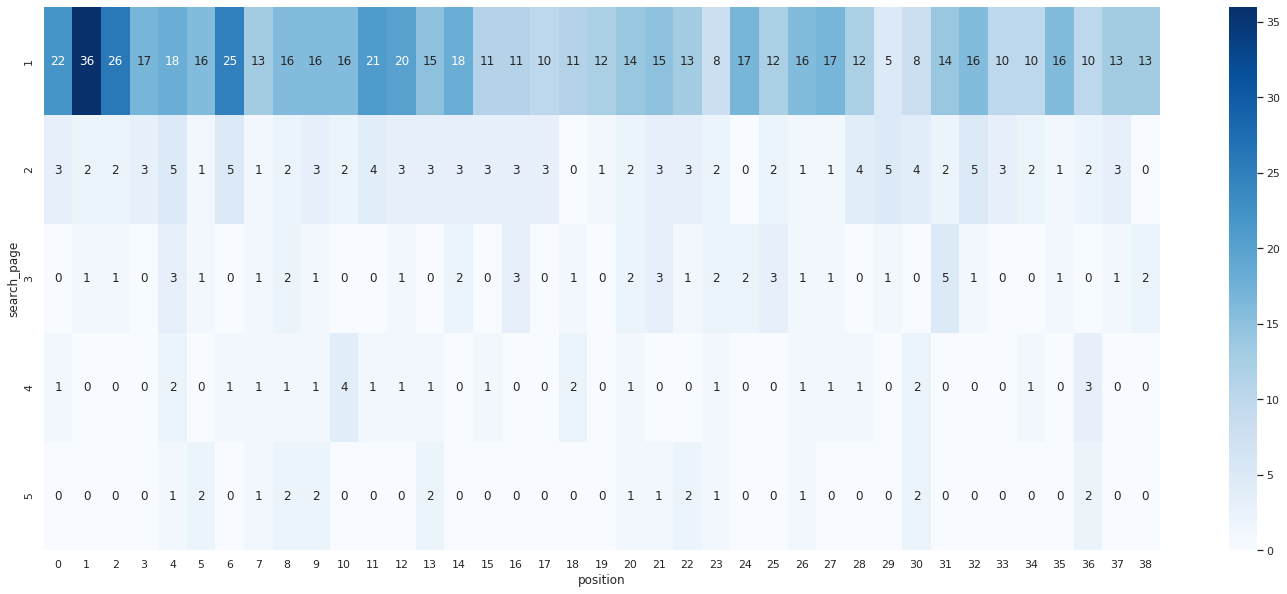

In [17]:
display(HTML('<h3>Produtos por Clusters</h3>'))

selected_clusters = sorted(embeddings_frame
                           .drop_duplicates('cluster')
                           .sample(n=5, random_state=27)
                           ['cluster']
                           .tolist())

for cluster in selected_clusters:
    slice_frame = embeddings_frame.loc[lambda f: f['cluster'] == cluster]
    display(HTML(f'<h4>Cluster: <strong>{cluster}</strong> [{len(slice_frame)} interações]</h4>'))
    #display(HTML('Buscas:'))
    #plot_word_cloud(slice_frame.drop_duplicates('query')['query'].apply(partial_clean_text_fn).tolist())
    display(HTML(f'<p><strong>Categorias das interações</strong>: {" | ".join(sorted(slice_frame.category.unique().tolist()))}</p>'))

    display(HTML('Resultados:'))
    plot_word_cloud(slice_frame['title'].apply(partial_clean_text_fn).tolist())

    
    plot_query_heatmap(format_search_space(slice_frame), display_values=True)
    display(HTML('<br /><br /><br />'))
    
del slice_frame, selected_clusters

Ainda que os grupos possam compartilhar algumas semelhanças entre si, eles permitem estabelecer zonas de similaridade de conteúdo e ajudam a determinar o quão frequentemente os resultados de uma consulta mudam essas zonas. Primeiro, verifica-se a distribuição da quantidade de produtos por buscas.

Buscas com 1 elemento: 1463(24.59%)


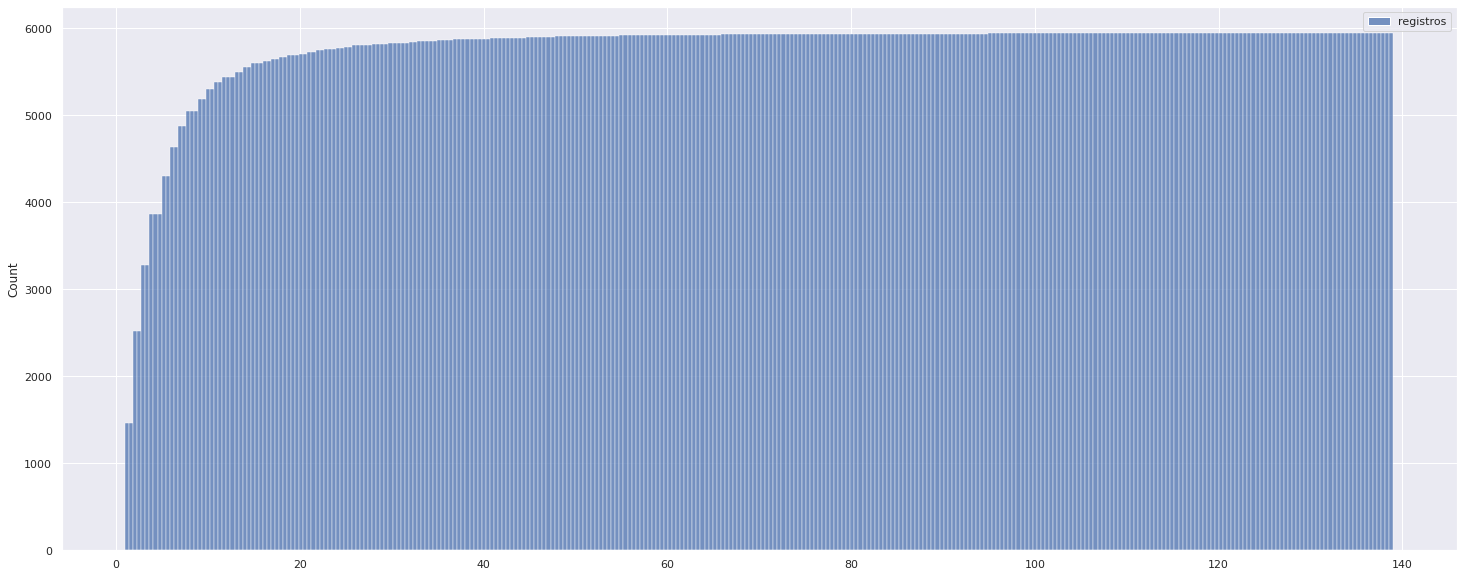

In [18]:
agg_frame = (frame
             [['query']]
             .assign(registros=1)
             .groupby('query')
             .sum()
             .reset_index())

single_product_search = len(agg_frame.loc[lambda f: f['registros'] <= 1])
all_searches = len(agg_frame)

print(f'Buscas com 1 elemento: {single_product_search}({single_product_search/all_searches * 100:.2f}%)')

sns.histplot(agg_frame, cumulative=True)
plt.show()

del agg_frame, single_product_search, all_searches

A distribuição permite entender que a eliminação de buscas com resultados únicos elimina cerca de 25% dos registros e que a quantidade de itens em buscas tende a cair pela metade à medida que se contabiliza o total de itens.

A seguir, a metodologia de cálculo de entropia volta a ser aplicada, agora considerando os grupos como critério de cálculo de entropia.

In [19]:
# Selecionar buscas com ao menos 2 elementos para identificar foco/dispersão.
qualified_queries = set(frame
                        [['query']]
                        .assign(registros=1)
                        .groupby('query')
                        .sum()
                        .reset_index()
                        .query('registros >= 2')
                        ['query']
                        .unique()
                        .tolist()
                       )

# Separar embeddings e atributos de interesse das buscas selecionadas
embeddings_entropy_frame = (embeddings_frame
                            .loc[lambda f: f['query'].isin(qualified_queries)]
                            [['query', 'query_embedding', 'query_embedding_reduced_x', 'query_embedding_reduced_y', 'cluster']]
                            .drop_duplicates('query')
                           )

# Calcular entropia dos produtos com interação das buscas e guardar número de clusters e produtos
entropies = []
clusters = []
products = []

for query in embeddings_entropy_frame['query'].unique().tolist():
    frame_slice = (embeddings_frame
                   .loc[lambda f: f['query'] == query]
                  )

    entropies.append(compute_entropy(frame_slice.cluster.to_numpy()))
    clusters.append(len(frame_slice.cluster.unique().tolist()))
    products.append(len(frame_slice.title.unique().tolist()))

embeddings_entropy_frame['entropy'] = entropies
embeddings_entropy_frame['clusters'] = clusters
embeddings_entropy_frame['products'] = products

del frame_slice, entropies, clusters, products

Para permitir estabelecer um critério de corte de entropia para determinar se uma busca é focada ou não, exibe-se a distribuição de entropia das buscas.

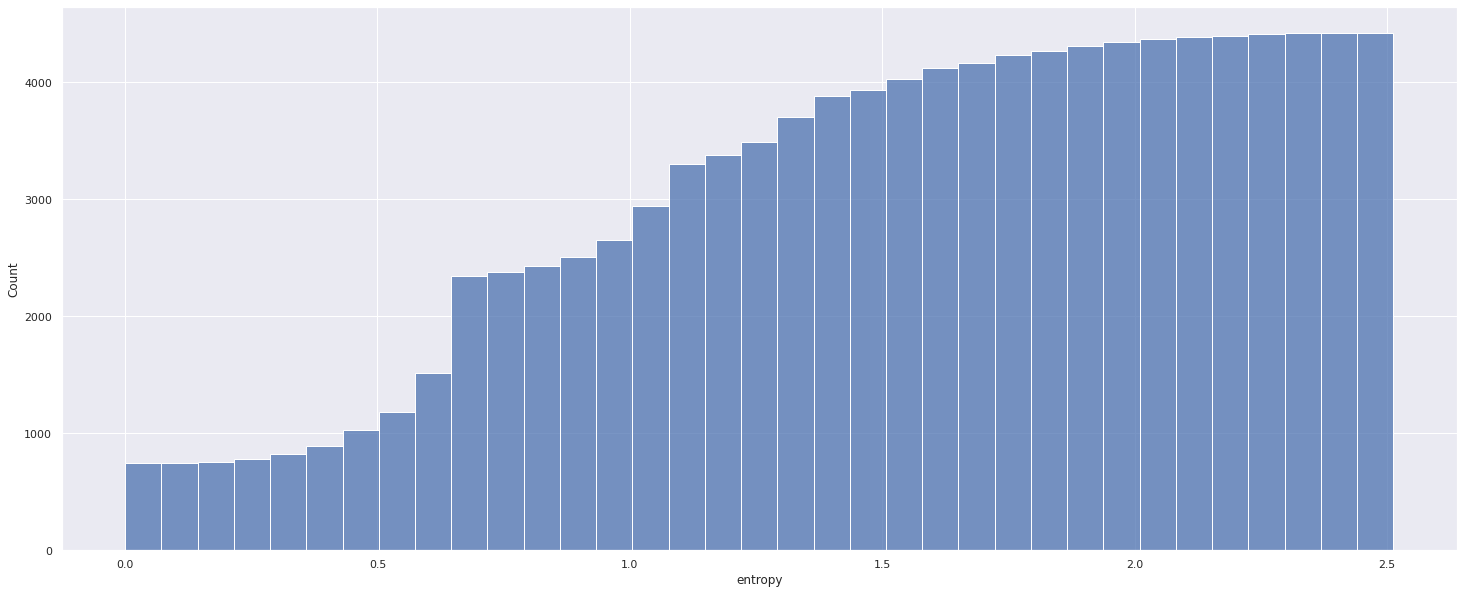

In [20]:
sns.histplot(embeddings_entropy_frame.query('products >= 2')['entropy'], cumulative=True)
plt.show()

Pelo gráfico, é possível o notal o salto na entropia a partir um valor de aproximadamente 0.65. Usando esse critério como base, estabelecendo que buscas com uma entropia menor ou iqual a 0.65 são mais homogêneas, pode-se verificar o comportamento dos dados.

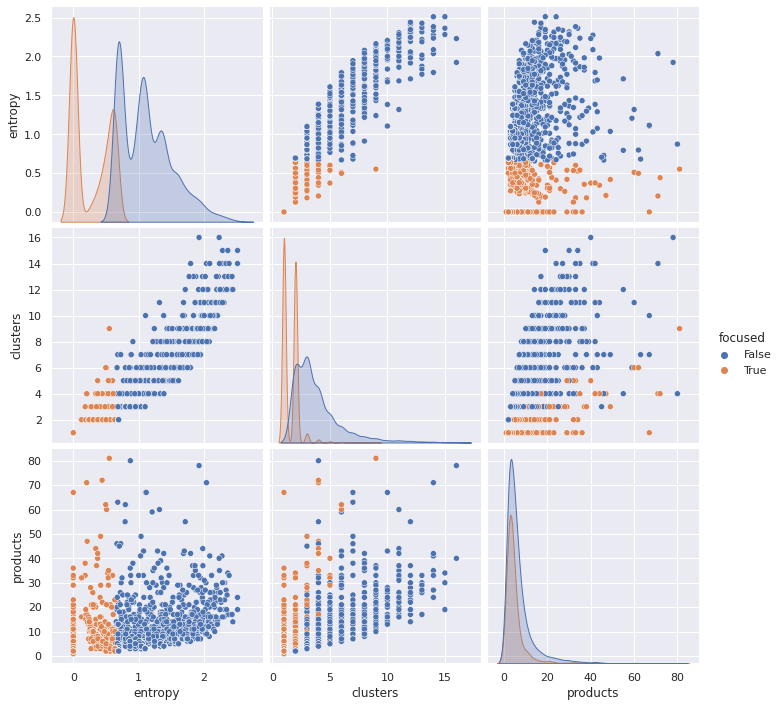

In [21]:
entropy_threshold = 0.65 #.65
sns.pairplot(embeddings_entropy_frame
             .assign(focused=lambda f: f['entropy'] <= entropy_threshold)
             [['entropy', 'clusters', 'products', 'focused']], height=3.33, hue='focused')
plt.show()

Pelo que a imagem mostra, é possível ter buscas com o comportamento de "foco" mesmo com uma quantidade grande de elementos (acima de 40). Também há casos de perfis focados mesmo com mais de 5 clusters, provavelmente com alguns produtos destoando com relação ao grupo, mas entre uma quantidade numerosa de produtos de mesmo grupo. Esses comportamentos podem indicar que essas duas intenções ("foco" e "exploração") podem ser subdivididas, mas isso deve ficar fora do escopo deste projeto.

Considernado essa divisão de produtos como ponto de partida para a definição de intenções, é preciso tentar prever quando uma busca indica um comportamento de "foco" ou de "exploração" tendo apenas o próprio conteúdo da busca, sem os produtos resultantes. Para isso, pode-se utilizar os dados de treinamento já associados a um cluster para treinar um modelo de classificação binária. Os embeddings da busca podem auxiliar, porém, conforme o gráfico abaixo indica, eles sozinhos podem ser ser o suficiente para atingir uma boa eficácia de predição. Deve-se fazer a extração de mais catecterísticas (e.g., quantidade de termos, presença de números, dentre outros), para ajudar na caterização da intenção.

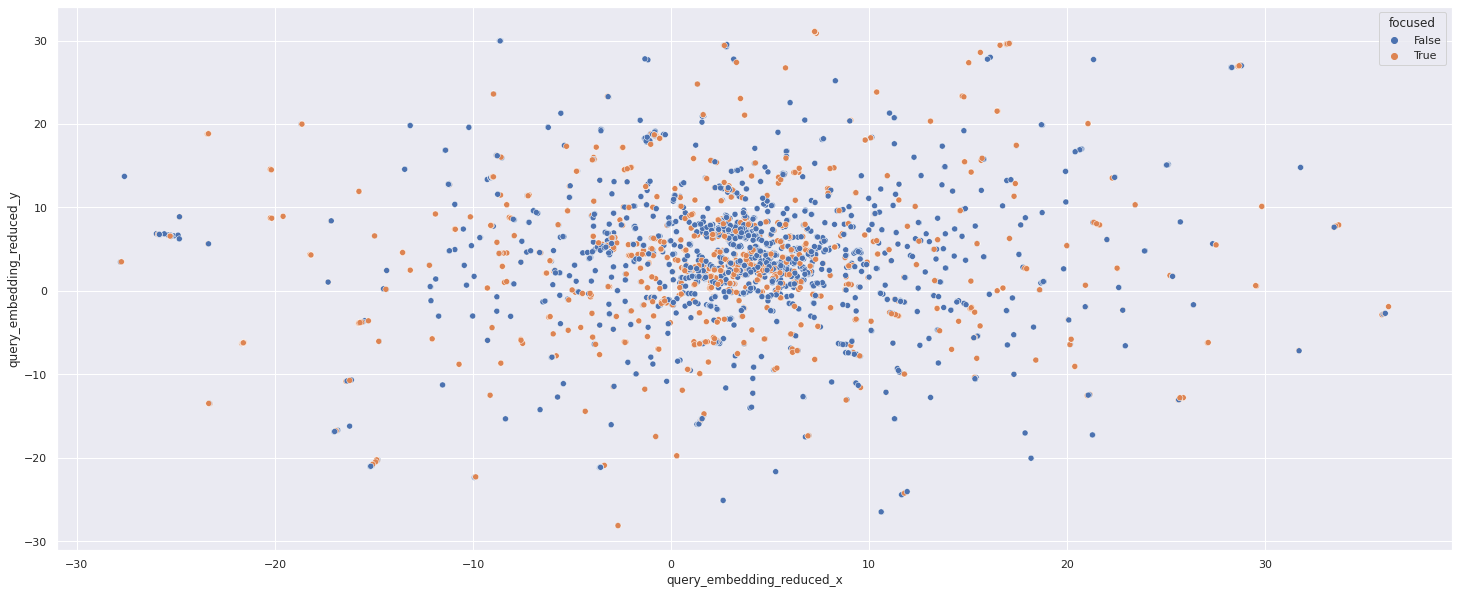

In [22]:
embeddings_entropy_frame = (embeddings_entropy_frame
                            .assign(focused=lambda f: f['entropy'] <= entropy_threshold)
                           )

plot_query_embeddings(embeddings_entropy_frame,
                      f'query_embedding_reduced_x',
                      f'query_embedding_reduced_y',
                      'query',
                      'focused'
                     )